## Old function testing

In [ ]:
from grasp_generator import GraspGenerator
from environment.utilities import Camera
from environment.env import Environment
from utils import YcbObjects, PackPileData, IsolatedObjData, summarize
import numpy as np
import pybullet as p
import argparse
import os
import sys
import cv2
import math
import matplotlib.pyplot as plt
import time
import skimage.io

from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.coco import coco

# Root directory of the project
ROOT_DIR = os.path.abspath('/home/ivar/Documents/Thesis/clutterbot/')

In [ ]:
def make_mask(vis):
    CAM_Z = 1.9
    IMG_SIZE = 224

    objects = YcbObjects('objects/ycb_objects',
                        mod_orn=['ChipsCan', 'MustardBottle', 'TomatoSoupCan'],
                        mod_stiffness=['Strawberry'])
    
    cracker_path = 'objects/ycb_objects/YcbCrackerBox/model.urdf'
    hammer_path = 'objects/ycb_objects/YcbHammer/model.urdf'
    banana_path = 'objects/ycb_objects/YcbBanana/model.urdf'

    ## camera settings: cam_pos, cam_target, near, far, size, fov
    center_x, center_y, center_z = 0.05, -0.52, CAM_Z
    camera = Camera((center_x, center_y, center_z), (center_x, center_y, 0.785), 0.2, 2.0, (IMG_SIZE, IMG_SIZE), 40)
    env = Environment(camera, vis=vis, finger_length=0.06)

    env.reset_robot()          
    env.remove_all_obj()                        
    
    env.load_isolated_obj(banana_path)

    # number_of_objects = 5
    # objects.shuffle_objects()
    # info = objects.get_n_first_obj_info(number_of_objects)
    # env.create_pile(info)

    # segmentation mask of the image where pixels each contain unique integers with object IDs
    # yields integer values: upper rectangle of 1, lower of 4
    # with mask as 6 (in the case of single object!!)
    _, _, seg = camera.get_cam_img()

    ## convert to numpy and binarize (i.e. filter for 6, since value for single mask)
    numpy_mask = (np.array(seg) == 6).astype(int)

    ## convert back to matrix
    mask = np.asmatrix(numpy_mask)

    plt.imshow(mask, interpolation='nearest')
    plt.show()
    # skimage.io.imshow(np.asmatrix(seg))


In [ ]:
def look_at_banana(vis):
    CAM_Z = 1.9
    IMG_SIZE = 224

    def setup_mrcnn():
        # Directory to save logs and trained model
        MODEL_DIR = os.path.join(ROOT_DIR, 'logs')
        # Local path to your trained weights file
        COCO_MODEL_PATH = os.path.join(ROOT_DIR, 'mrcnn/weights/mask_rcnn_coco.h5')

        class InferenceConfig(coco.CocoConfig):
            GPU_COUNT = 1
            IMAGES_PER_GPU = 1
            
        config = InferenceConfig()

        class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
                    'bus', 'train', 'truck', 'boat', 'traffic light',
                    'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
                    'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
                    'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
                    'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
                    'kite', 'baseball bat', 'baseball glove', 'skateboard',
                    'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
                    'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
                    'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
                    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
                    'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
                    'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
                    'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
                    'teddy bear', 'hair drier', 'toothbrush']

        # Create model object in inference mode.
        model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

        # Load weights trained on the COCO dataset 
        model.load_weights(COCO_MODEL_PATH, by_name=True)

        return model, class_names

    model, class_names = setup_mrcnn()

    def evaluate():
        start = time.time()

        results = model.detect([rgb], verbose=1)
        r = results[0]
        box, mask, classID, score = r['rois'], r['masks'], r['class_ids'], r['scores']                      

        end = time.time()
        print('MRCNN EXECUTION TIME: ', end - start)

        return box, mask, classID, score

    objects = YcbObjects('objects/ycb_objects',
                        mod_orn=['ChipsCan', 'MustardBottle', 'TomatoSoupCan'],
                        mod_stiffness=['Strawberry'])
    
    banana_path = 'objects/ycb_objects/YcbBanana/model.urdf'

    ## camera settings: cam_pos, cam_target, near, far, size, fov
    center_x, center_y, center_z = 0.05, -0.52, CAM_Z
    # camera = Camera((center_x, center_y, center_z), (center_x, center_y, 0.785), 0.2, 2.0, (self.IMG_SIZE, self.IMG_SIZE), 40)
    
    MRCNN_IMG_SIZE = 1024
    camera = Camera((center_x, center_y, center_z), (center_x, center_y, 0.785), 0.2, 2.0, (MRCNN_IMG_SIZE, MRCNN_IMG_SIZE), 40)
    env = Environment(camera, vis=vis, finger_length=0.06)

    env.reset_robot()          
    env.remove_all_obj()                        
    
    # load banana into environment
    env.load_isolated_obj(banana_path)

    number_of_objects = 5
    # objects.shuffle_objects()
    # info = objects.get_n_first_obj_info(number_of_objects)
    # env.create_pile(info)

    rgb, _, _ = camera.get_cam_img()

    
    # for i in range(7):
    #     start = time.time()
    #     # path = 'trained_models/Mask_RCNN/images/' + str(i) + '.jpg'
    #     path = 'images/' + str(i) + '.jpg'
    #     print(path)
    #     rgb = skimage.io.imread(path)
    #     results = model.detect([rgb], verbose=1)
    #     r = results[0]
    #     box, mask, classID, score = r['rois'], r['masks'], r['class_ids'], r['scores']

    #     end = time.time()
    #     print('MRCNN EXECUTION TIME: ', end - start)

    #     visualize.display_instances(rgb, box, mask, classID, class_names, score)

    bananaFound = False
    nfNumber = 1

    box, mask, classID, score = evaluate()

    while(not bananaFound):
        if (47 in classID):
            print('BANANA FOUND')
            bananaFound = True

            result = np.where(classID == 47)
            index = result[0][0]
            print('index: ', index)
            # terminaloutput>> index:  (array([3]),)
            # pak eerste output: result = np.where(classID == 47) \ index = result[0][0]
            # https://thispointer.com/find-the-index-of-a-value-in-numpy-array/
        else:
            print('NOT FOUND, starting again')

            # visualize.display_instances(rgb, box, mask, classID, class_names, score, title='notfound ' + str(nfNumber))
            
            nfNumber += 1

            env.reset_robot()          
            env.remove_all_obj()
            objects.shuffle_objects()
            info = objects.get_n_first_obj_info(number_of_objects)
            env.create_pile(info)

            rgb, _, _ = camera.get_cam_img()

            box, mask, classID, score = evaluate()
    
    print('NOT FOUND #', nfNumber)
    visualize.display_instances(rgb, box, mask, classID, class_names, score)


In [ ]:
def turn_object():
    CAM_Z = 1.9
    IMG_SIZE = 1024

    # objects = YcbObjects('objects/ycb_objects',
    #                     mod_orn=['ChipsCan', 'MustardBottle', 'TomatoSoupCan'],
    #                     mod_stiffness=['Strawberry'])

    ## camera settings: cam_pos, cam_target, near, far, size, fov
    center_x, center_y, center_z = 0.05, -0.52, CAM_Z
    camera = Camera((center_x, center_y, center_z), (center_x, center_y, 0.785), 0.2, 2.0, (IMG_SIZE, IMG_SIZE), 40)
    env = Environment(camera, vis=True, finger_length=0.06)

    def no_object_found():
        rgb, depth, _ = camera.get_cam_img()
        if (depth.max()- depth.min() < 0.0025):
            return True
        else:
            return False  

    # obj_path = 'objects/ycb_objects/YcbChipsCan/model.urdf'
    # objects = ['ChipsCan', 'CrackerBox', 'GelatinBox', 'MasterChefCan', 'MustardBottle', 'PottedMeatCan',
    #         'PowerDrill', 'TomatoSoupCan']
    objects = ['Scissors']
    i = 0
    while(True):
        obj_path = 'objects/ycb_objects/Ycb' + objects[i] + '/model.urdf'
        for _ in range(50):
            env.reset_robot()          
            env.remove_all_obj()

            pitch = bool(random.getrandbits(1))
            roll = bool(random.getrandbits(1))
            
            env.load_turnable_obj(obj_path, pitch, roll)

            for _ in range(20):
                    p.stepSimulation()
            if(no_object_found()):
                print("EMPTY DESK")
        i+=1

In [ ]:
def make_mask(vis):
    CAM_Z = 1.9
    IMG_SIZE = 224

    objects = YcbObjects('objects/ycb_objects',
                        mod_orn=['ChipsCan', 'MustardBottle', 'TomatoSoupCan'],
                        mod_stiffness=['Strawberry'])
    
    cracker_path = 'objects/ycb_objects/YcbCrackerBox/model.urdf'
    hammer_path = 'objects/ycb_objects/YcbHammer/model.urdf'
    banana_path = 'objects/ycb_objects/YcbBanana/model.urdf'

    ## camera settings: cam_pos, cam_target, near, far, size, fov
    center_x, center_y, center_z = 0.05, -0.52, CAM_Z
    camera = Camera((center_x, center_y, center_z), (center_x, center_y, 0.785), 0.2, 2.0, (IMG_SIZE, IMG_SIZE), 40)
    env = Environment(camera, vis=vis, finger_length=0.06)

    env.reset_robot()          
    env.remove_all_obj()                        
    
    env.load_isolated_obj(banana_path)

    # number_of_objects = 5
    # objects.shuffle_objects()
    # info = objects.get_n_first_obj_info(number_of_objects)
    # env.create_pile(info)

    # segmentation mask of the image where pixels each contain unique integers with object IDs
    # yields integer values: upper rectangle of 1, lower of 4
    # with mask as 6 (in the case of single object!!)
    _, _, seg = camera.get_cam_img()

    ## convert to numpy and binarize (i.e. filter for 6, since value for single mask)
    numpy_mask = (np.array(seg) == 6).astype(int)

    ## convert back to matrix
    mask = np.asmatrix(numpy_mask)

    # skimage.io.imshow(np.asmatrix(seg))
    plt.imshow(mask, interpolation='nearest')
    plt.show()

In [ ]:
def drawBox():
    
    CAM_Z = 1.9

    model, class_names = setup_mrcnn('custom', 'tex/tex100_800st2_endEp30_val0.24/weights.bestVal.hdf5', 0.7)
    banana_path = 'objects/ycb_objects/YcbBanana/model.urdf'
    powerdrill_path = 'objects/ycb_objects/YcbPowerDrill/model.urdf'

    center_x, center_y, center_z = 0.05, -0.52, CAM_Z
    MRCNN_IMG_SIZE = 448
    camera = Camera((center_x, center_y, center_z), (center_x, center_y, 0.785), 0.2, 2.0, (MRCNN_IMG_SIZE, MRCNN_IMG_SIZE), 40)
    env = Environment(camera, vis=vis, finger_length=0.06)


    for _ in range(10):
        env.reset_robot()          
        env.remove_all_obj()
        # env.load_obj_same_place(banana_path)
        env.load_isolated_obj(powerdrill_path)

        rgb, _, _ = camera.get_cam_img()
        box, mask, classID, score = evaluate_mrcnn(model, rgb)
        # visualize.display_instances(rgb, box, mask, classID, class_names, score)
    
        bestBox = box[0]        
        lines = draw_box(bestBox)

        for _ in range(40):
            p.stepSimulation()
        
        remove_box(lines)

## Mask & Background

Mask making

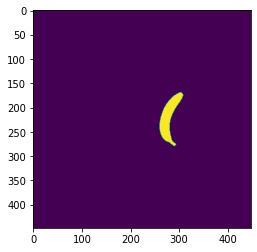

In [3]:
import matplotlib.pyplot as plt
import json
import numpy as np

annotations1 = json.load(open('data/train/train_img_data.json'))
ann = list(annotations1.values())

# print(ann)

inst = ann[0]

mask = np.zeros(shape=(inst['height'],inst['width']))
#print event.x, event.y
mask[inst['mask_y'],inst['mask_x']]=1

plt.imshow(mask)

Background randomization

In [ ]:
# import imgaug.imgaug as ia
# import skimage.io
import json
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image



img = plt.imread('data/trial/Banana0.jpg')
annotations1 = json.load(open('data/trial/trial_img_data.json'))
ann = list(annotations1.values())
inst = ann[0]

mask = np.zeros(shape=(inst['height'],inst['width']), dtype=int)
mask[inst['mask_y'],inst['mask_x']]=1

# pic = mask
# pic[inst['mask_y'],inst['mask_x']] = img[inst['mask_y'],inst['mask_x']]

# imarray = np.random.rand(448,448,3) * 255
# imarray[inst['mask_y'],inst['mask_x']] = img[inst['mask_y'],inst['mask_x']]
# im = Image.fromarray(imarray.astype('uint8'))

plt.figure()
plt.imshow(mask)

plt.figure()
plt.imshow(img)
# print(pic.shape)
# print(mask.shape)
# print(img.shape)


Textures

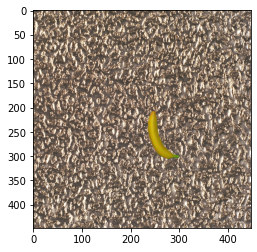

In [55]:
import os, random
import skimage.io as sk
import numpy as np
from matplotlib import pyplot as plt
import json
from PIL import Image

path = 'images/textures/use/'
im_name = random.choice(os.listdir('images/textures/use'))
texture = Image.open(path + im_name)

img = plt.imread('data/trial/Banana0.jpg')
annotations1 = json.load(open('data/trial/trial_img_data.json'))
ann = list(annotations1.values())
inst = ann[0]

mask = np.zeros(shape=(inst['height'],inst['width']), dtype=int)
mask[inst['mask_y'],inst['mask_x']]=1


resized = np.asarray(texture.resize((448,448)))
resized[inst['mask_y'],inst['mask_x']] = img[inst['mask_y'],inst['mask_x']]
im = Image.fromarray(resized.astype('uint8'))

# plt.figure()
# plt.imshow(im)

## Plot graphs

Manual data (Val & Loss)

In [ ]:
import matplotlib.pyplot as plt

loss = [1.1854, 0.6303, 0.5300, 0.4471, 0.3668, 0.3818, 0.3519, 0.3243, 0.3217, 0.2790,  0.2806, 0.2720, 0.2712, 0.2580, 0.2468, 0.2446, 0.2336, 0.2119, 0.2258, 0.2184, 0.2039, 0.2062, 0.2179, 0.1969, 0.1861, 0.1846, 0.1862, 0.1799, 0.2046, 0.1752, 0.1701, 0.1734, 0.1577, 0.1603, 0.1637, 0.1622, 0.1674, 0.1594, 0.1491, 0.1512]

val = [0.7095, 0.6066, 0.6826, 0.4511, 0.5400, 0.3894, 0.2554, 0.2673, 0.2726, 0.3397, 0.3223, 0.2163, 0.2183, 0.1952, 0.2046, 0.2100, 0.2505, 0.2568, 0.2263, 0.3240, 0.2153, 0.2642, 0.1634, 0.1830, 0.1943, 0.2243, 0.1232, 0.1529, 0.1783, 0.1943, 0.1483, 0.1383, 0.1829, 0.1319, 0.1848, 0.1452, 0.1530, 0.1272, 0.1695, 0.1549]

loss = [0.7527, 0.4090, 0.3487, 0.3253, 0.3063, 0.2642, 0.2786, 0.2387, 0.2781, 0.2389, 0.2216, 0.2059, 0.2043, 0.1981, 0.1896, 0.1848, 0.1700, 0.1748, 0.1782, 0.1669]

val = [0.4954, 0.3858, 0.3179, 0.2969, 0.3067, 0.3904, 0.3154, 0.2596, 0.2825, 0.2655, 0.1602, 0.1971, 0.2303, 0.2390, 0.1835, 0.1770, 0.1619, 0.1619, 0.2032, 0.1933]

plt.plot(loss, '-b', label='loss')
plt.plot(val, '-r', label='val')

plt.xlim([0, 20])
# plt.ylim([0, 1.0])

plt.xlabel("epoch")
plt.legend(loc='upper right')
plt.title('Training loss vs validation loss')

# plt.plot(loss)
# plt.show()

# plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.savefig('my_plot.png')
# plt.savefig('whatever.png', facecolor=plt.get_facecolor(), edgecolor='none')


# Testing

Config

In [1]:
import os
import matplotlib.pyplot as plt
import time
import skimage.io

from mrcnn.config import Config
# from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

class CustomConfig(Config):
  NAME = "object"
  NUM_CLASSES = 1 + 16 
config = CustomConfig()

class InferenceConfig(config.__class__):
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1
  DETECTION_MIN_CONFIDENCE = 0.8
    
config = InferenceConfig()

class_names = ['BG', 'Banana', 'ChipsCan', 'CrackerBox', 'FoamBrick', 'GelatinBox', 'Hammer', 
                'MasterChefCan', 'MediumClamp', 'MustardBottle', 'Pear', 'PottedMeatCan', 'PowerDrill', 
                'Scissors', 'Strawberry', 'TennisBall', 'TomatoSoupCan']

model = modellib.MaskRCNN(mode="inference", model_dir='logs', config=config)

## Load weights
# ID = '/tex/rois1/val0.11'


# WEIGHTS_DIR = os.path.join('mrcnn/weights', ID)
# CUSTOM_MODEL_PATH = os.path.join(WEIGHTS_DIR, 'weights.bestVal.hdf5')
CUSTOM_MODEL_PATH = 'mrcnn/weights/tex/tex100_1600inst2_endEp12_val0.25/weights.bestVal.hdf5'

model.load_weights(CUSTOM_MODEL_PATH, by_name=True)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Instructions for updating:
Use fn_output_signature instead


## Statistical

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display

def init_df():
    objects = ['Banana', 'ChipsCan', 'CrackerBox', 'FoamBrick', 'GelatinBox', 'Hammer', 
                    'MasterChefCan', 'MediumClamp', 'MustardBottle', 'Pear', 'PottedMeatCan', 'PowerDrill', 
                    'Scissors', 'Strawberry', 'TennisBall', 'TomatoSoupCan']
    df = pd.DataFrame(0, index=objects, columns= (objects + ['EmptyPred', 'EPInstances']))
    df['EPInstances'] = np.empty((len(df), 0)).tolist()
    # display(df)
    
    return df

def test_model(df, nr_of_inst, test_objects):
    for obj in test_objects:
        if obj == 'BG': continue
        print("testing:", obj)

        for i in range(nr_of_inst):
            img = skimage.io.imread('data/test/iso/{}{}.jpg'.format(obj,i))
            results = model.detect([img], verbose=0)
            
            ## Check for empty prediction
            if not results[0]['rois'].shape[0]:
                df.at[obj,'EmptyPred'] += 1 
                df.at[obj, 'EPInstances'] += [i]
                continue
            
            ## Pick first and only? instance from results
            ## TODO catch possible muti object situations
            r = results[0]
            box, mask, classID, score = r['rois'], r['masks'], r['class_ids'], r['scores']
            prediction = class_names[classID[0]]

            df.at[obj, prediction] += 1

def show_performance(df, nr_of_inst, test_objects):
    correct = 0
    empty = 0

    for obj in test_objects:
        if obj == 'BG': continue
        correct += df.at[obj,obj]
        empty += df.at[obj, 'EmptyPred']

    total = nr_of_inst * 16
    performance = correct / total
    incorrect = total-(correct+empty)

    print("Performance: ")
    print("{:.2f}{} correct\n".format(performance*100,'%'))
    print(total, "total instances")
    print(empty, "instances with empty prediction")
    print(incorrect, "wrongly predicted")

def show_table(df):
    tempDF = df.copy()
    repl = {'Banana':'Ba', 'ChipsCan':'CC', 'CrackerBox':'CB', 'FoamBrick':'FB', 'GelatinBox':'GB', 'Hammer':'Ha', 'MasterChefCan':'MCC', 
    'MediumClamp':'MC', 'MustardBottle':'MB', 'Pear':'P', 'PottedMeatCan':'PM', 'PowerDrill':'PD', 'Scissors':'Sc', 'Strawberry':'St', 
    'TennisBall':'TB', 'TomatoSoupCan':'TS', 'EmptyPred': 'Empty'}
    tempDF.rename(index=repl, inplace=True)
    tempDF.rename(columns=repl, inplace=True)
    tempDF.replace(0,"", inplace=True)
    display(tempDF)

def show_conf_matrix(df, nr_of_inst, conf, hideZeros = False):
    tempDF = df.copy()
    tempDF.drop(columns=['EPInstances'], inplace=True)
    if (hideZeros): tempDF.replace(0,np.nan, inplace=True)

    # xlabels = ['B', 'CC', 'CB', 'FB', 'GB', 'H', 'MCC', 'MC', 'MB',
    #     'P', 'PM', 'PD', 'Sc', 'St', 'TB', 'TS']
    labels = ['Banana', 'ChipsCan', 'CrackerBox', 'FoamBrick', 'GelatinBox', 'Hammer', 
                    'MasterChefCan', 'MediumClamp', 'MustardBottle', 'Pear', 'PottedMeatCan', 'PowerDrill', 
                    'Scissors', 'Strawberry', 'TennisBall', 'TomatoSoupCan']

    plt.figure(figsize=(26,22))

    ax = sns.heatmap(tempDF.values, annot=True, cmap='OrRd')

    ax.set_title('Confusion Matrix of results with {} test instances and confidence {}\n\n'.format(nr_of_inst, conf));
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values \n');

    ax.xaxis.set_ticklabels(labels + ['Empty Prediction'])
    ax.yaxis.set_ticklabels(labels)

    ax.tick_params(axis='y', rotation=0)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

    plt.show()

def save_df(df, path):
    df.to_pickle(path)

def load_df(file_name):
    return pd.read_pickle(file_name)

In [ ]:
nr_of_inst = 13
test_objects = ['Banana', 'ChipsCan', 'CrackerBox', 'FoamBrick', 'GelatinBox', 'Hammer', 
            'MasterChefCan', 'MediumClamp', 'MustardBottle', 'Pear', 'PottedMeatCan', 'PowerDrill', 
            'Scissors', 'Strawberry', 'TennisBall', 'TomatoSoupCan']

df = init_df()
test_model(df, nr_of_inst, test_objects)

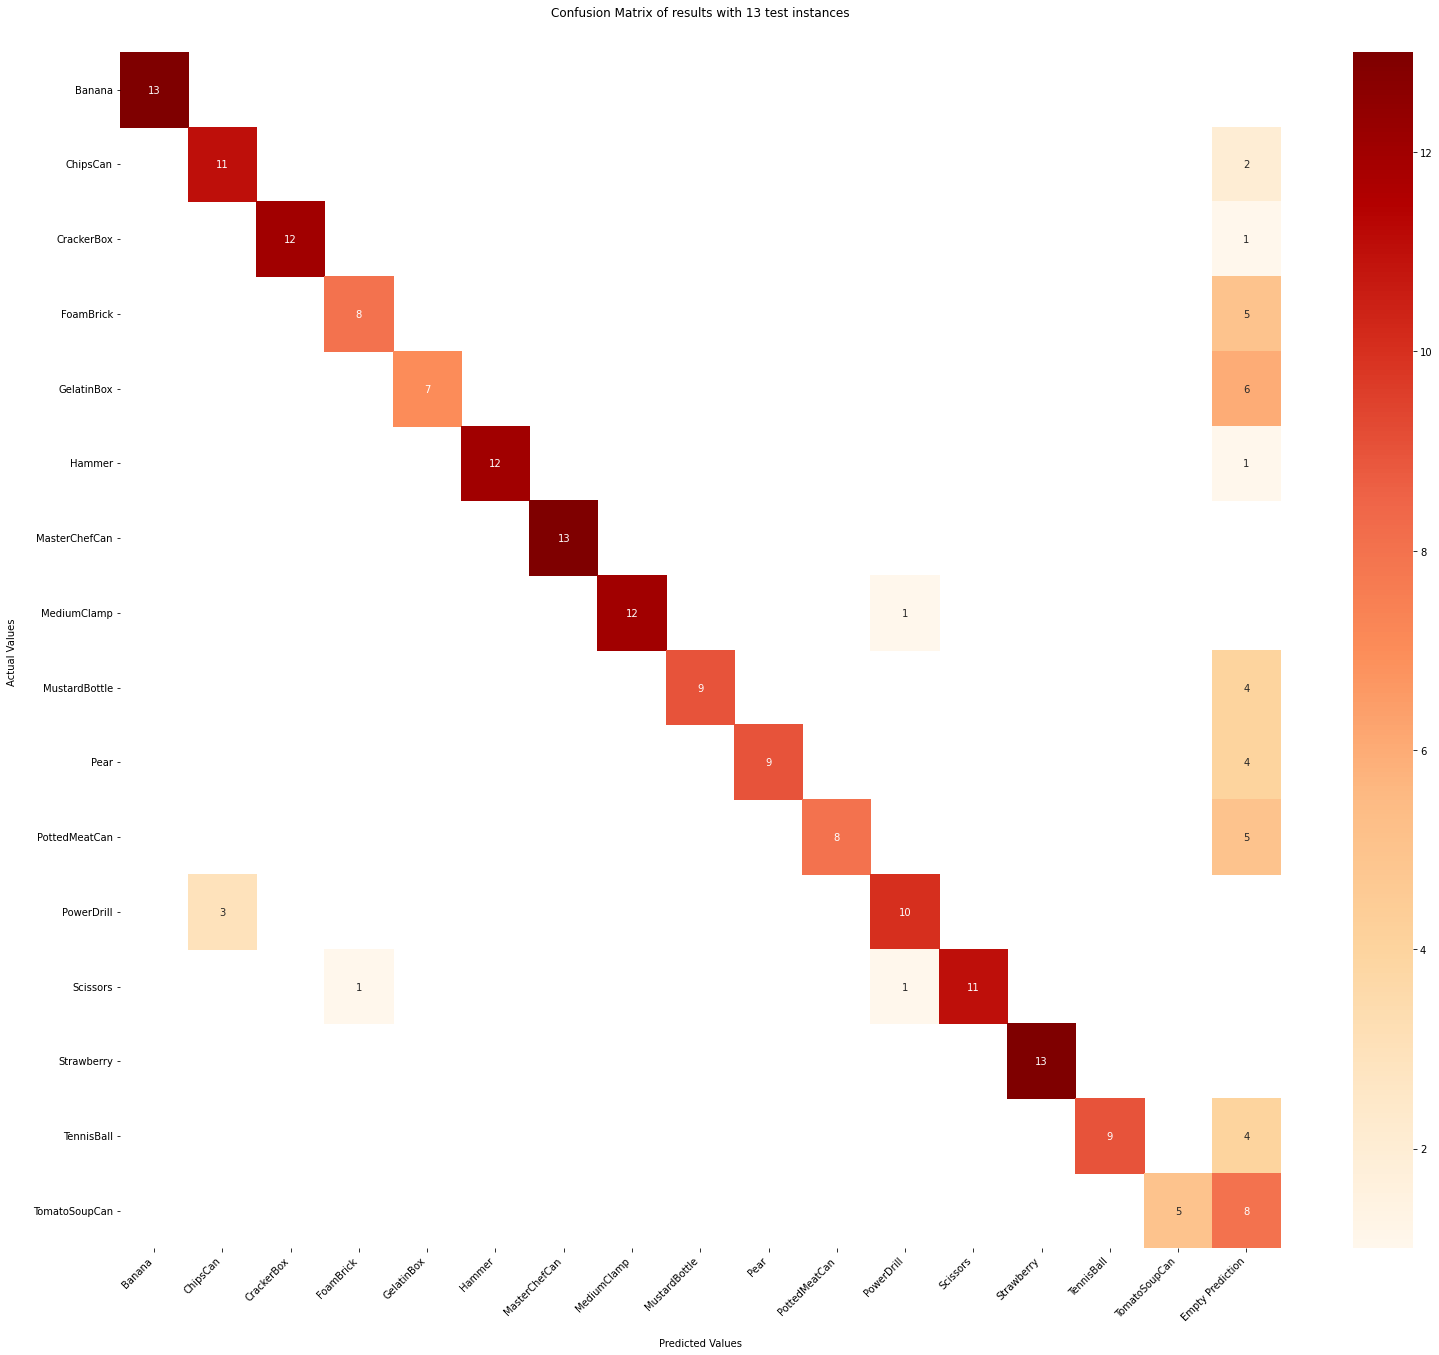

In [7]:
df = load_df('mrcnn/weights/tex/tex100_800st2_endEp30_val0.24/testRes_conf0.8_inst13.txt')
show_conf_matrix(df, 13, 0.7 True)

In [120]:
show_performance(df, nr_of_inst, test_objects)
show_table(df)
show_conf_matrix(df, nr_of_inst, 0.7)

NameError: name 'nr_of_inst' is not defined

In [15]:
save_df(df, WEIGHTS_DIR + 'testRes_conf0.8_inst13.txt')

## Visual

In [2]:
def test_iso(nr_of_inst, test_objects):
    for obj in test_objects:
        if obj == 'BG': continue

        for i in range(nr_of_inst):
            img = skimage.io.imread('data/test/iso/{}{}.jpg'.format(obj,i))
            results = model.detect([img], verbose=0)

            # get dictionary for first prediction
            image_results = results[0]
            r = results[0]

            visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

def test_pack_pile():
    scenes = ['pack','pile']
    for s in scenes:
        
        for i in range(3):
            img = skimage.io.imread('data/test/{}/{}{}.jpg'.format(s,s,i+1))
            results = model.detect([img], verbose=0)

            # get dictionary for first prediction
            image_results = results[0]
            r = results[0]

            visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

0.8


/home/ivar/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


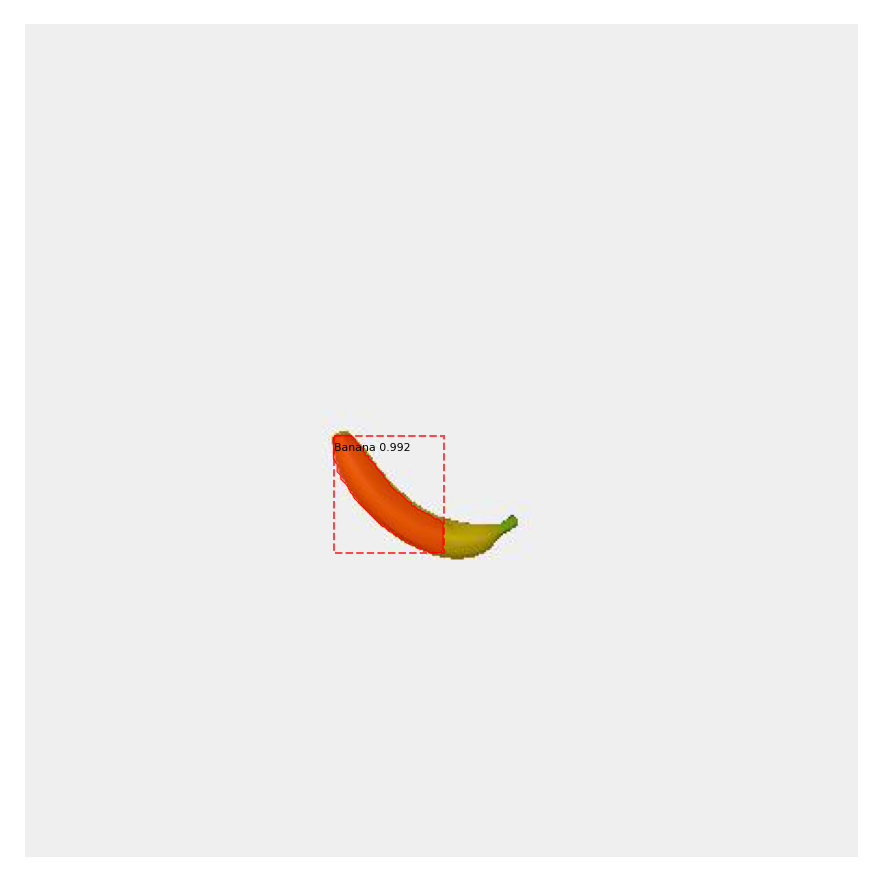

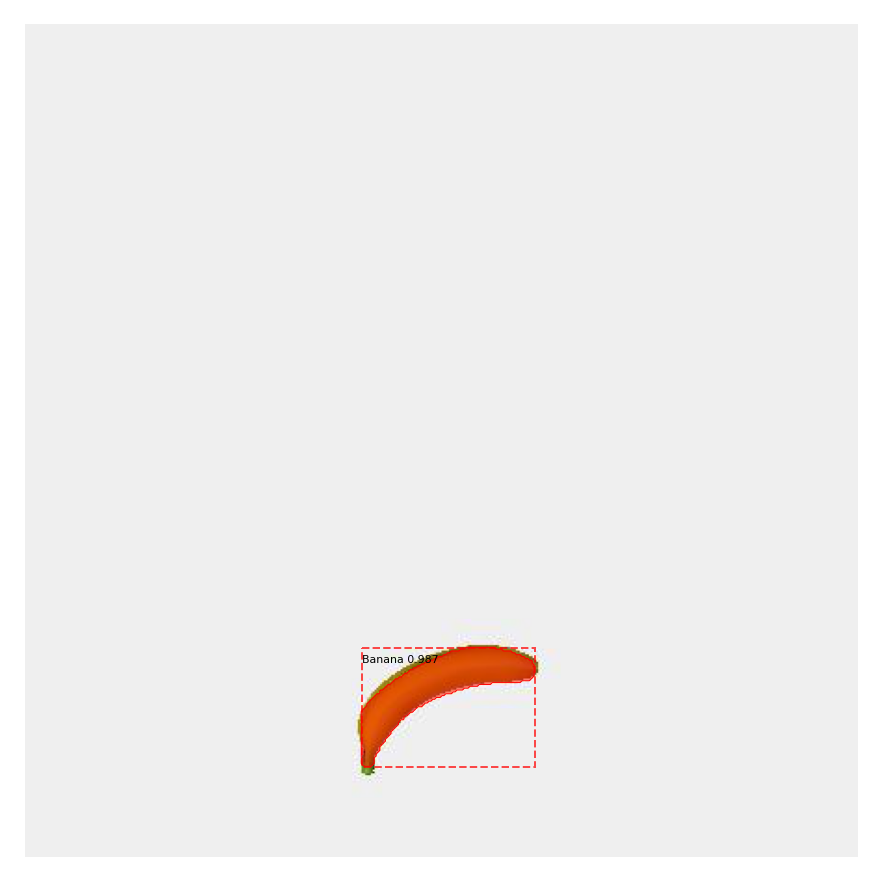

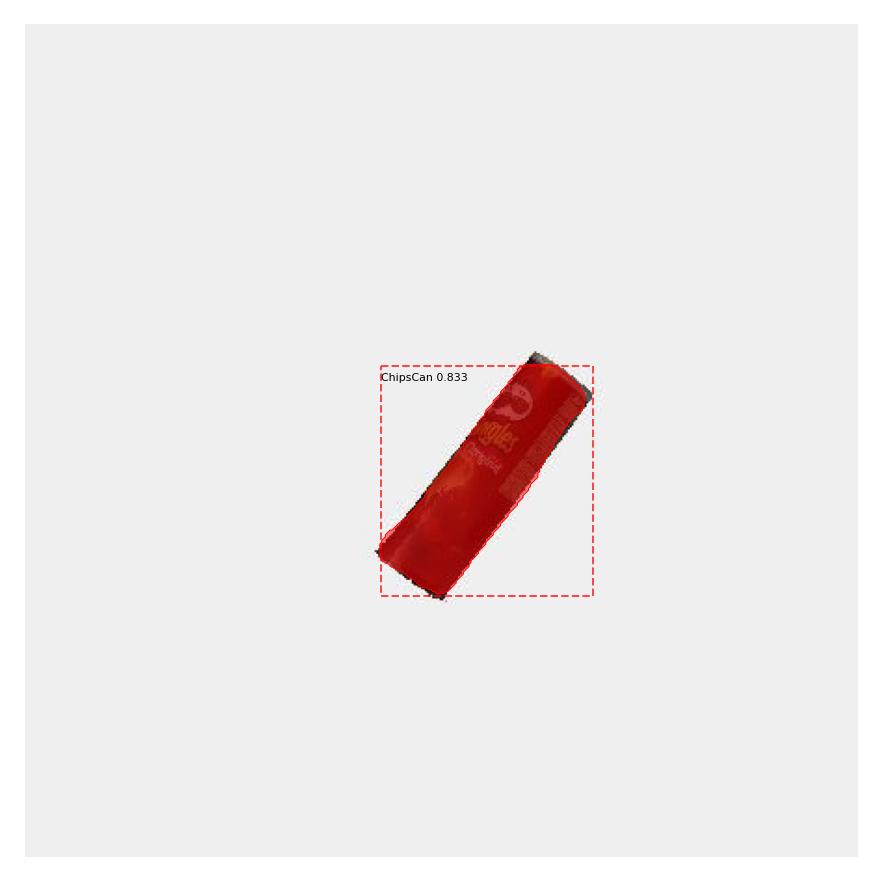

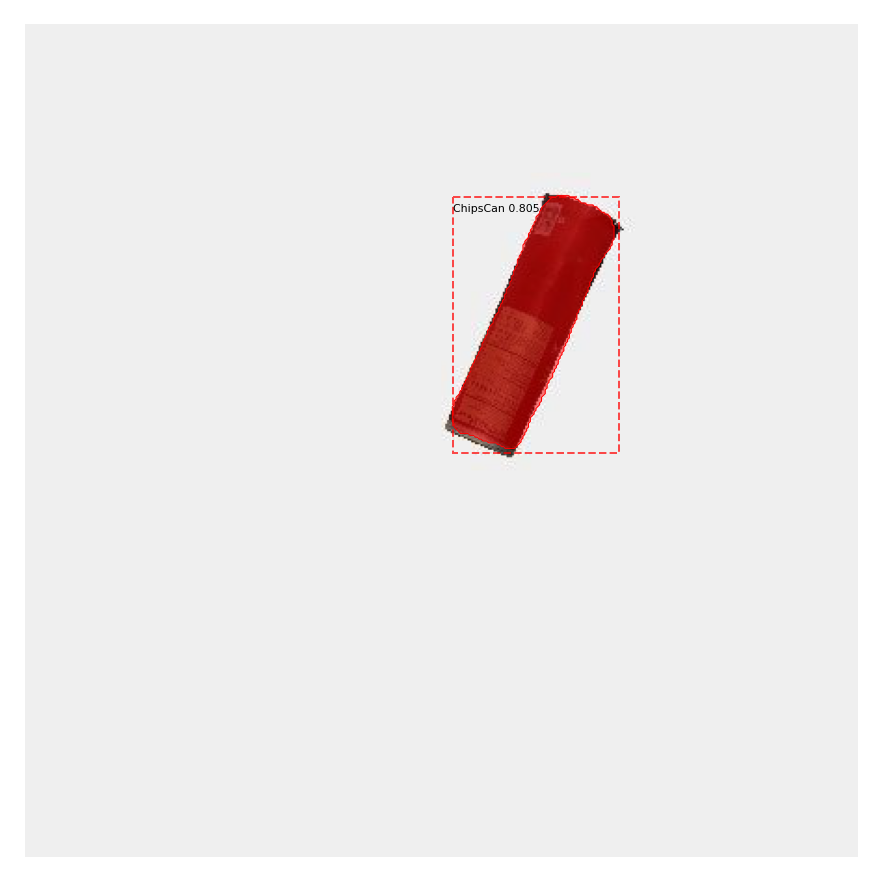

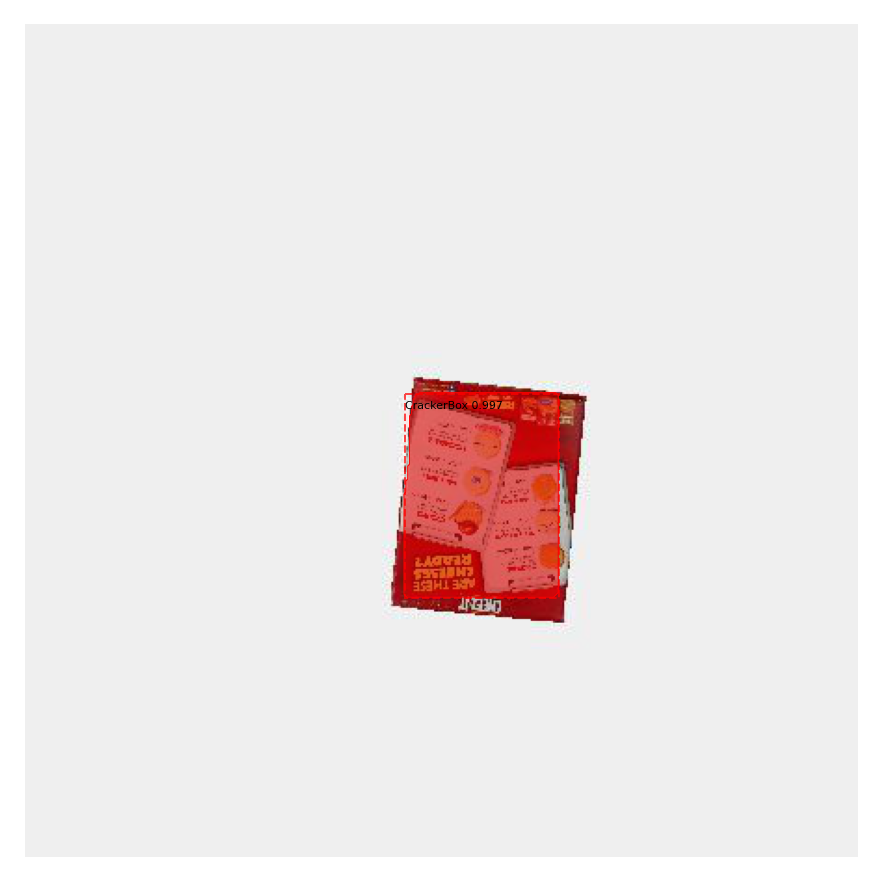

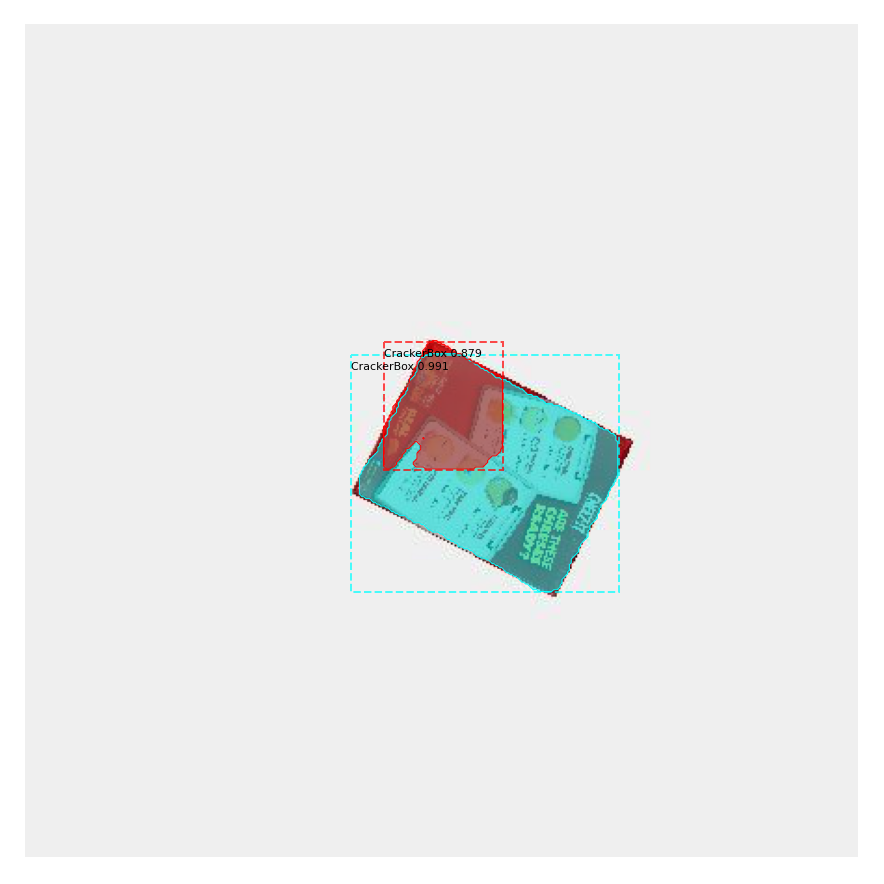


*** No instances to display *** 



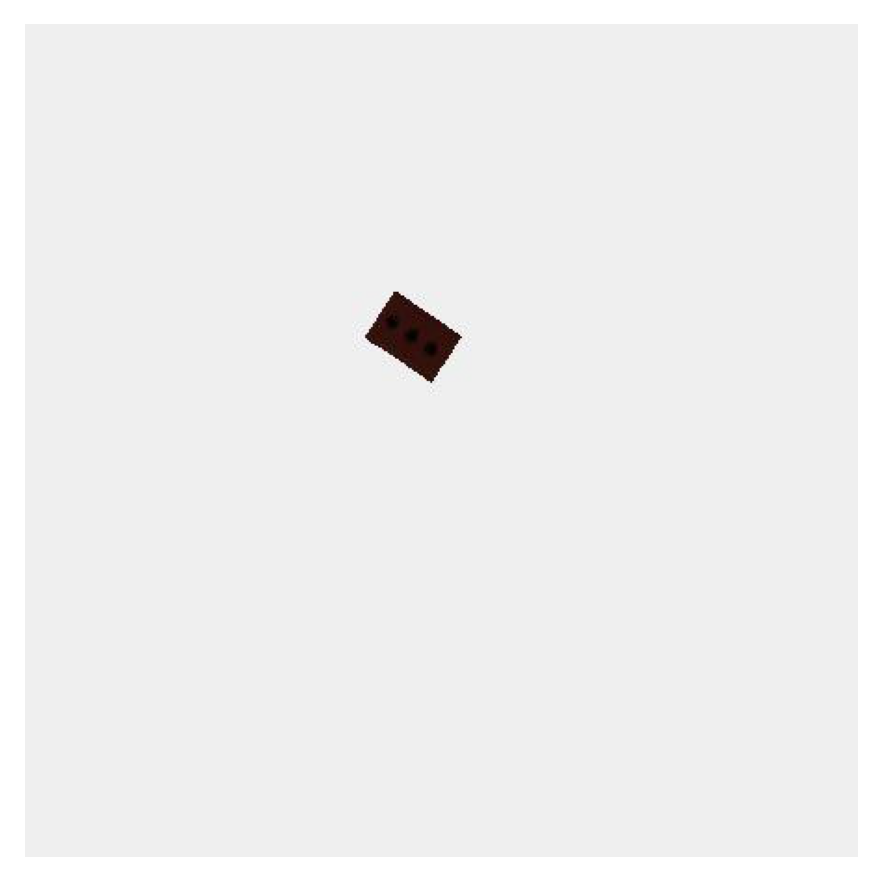


*** No instances to display *** 



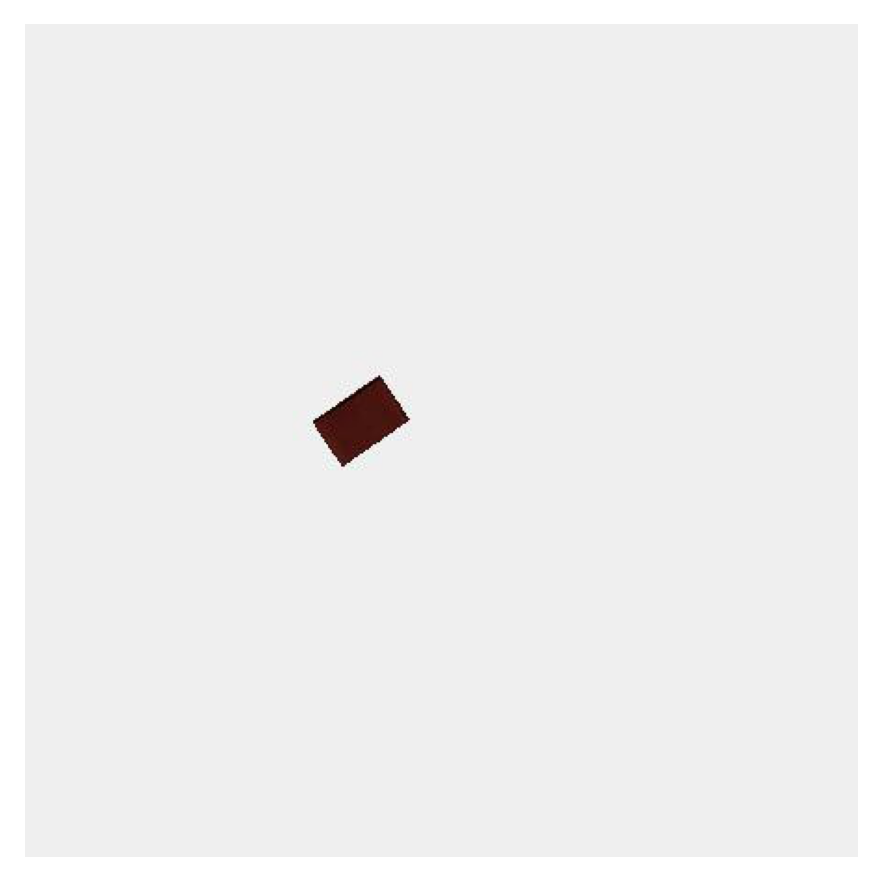


*** No instances to display *** 



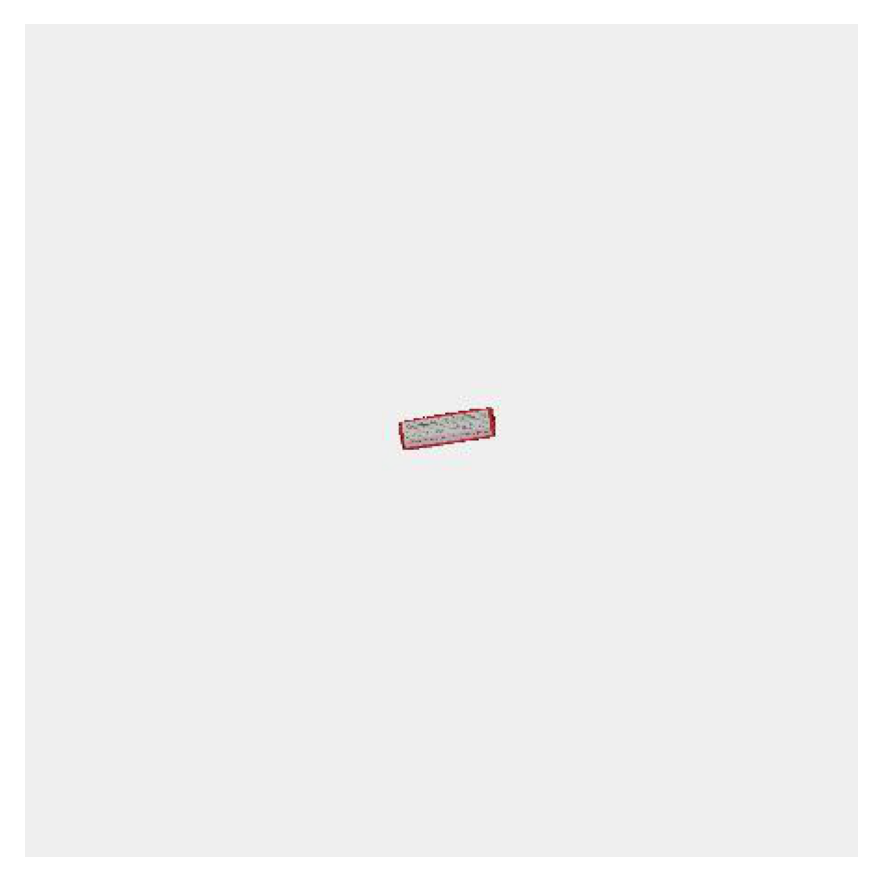

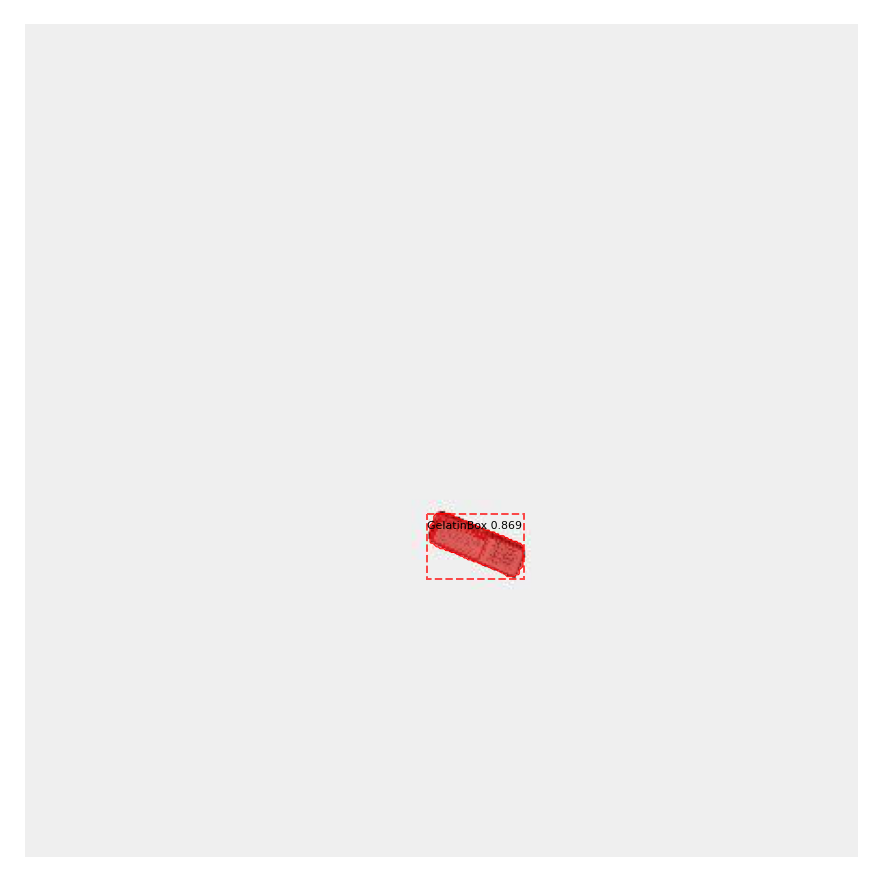

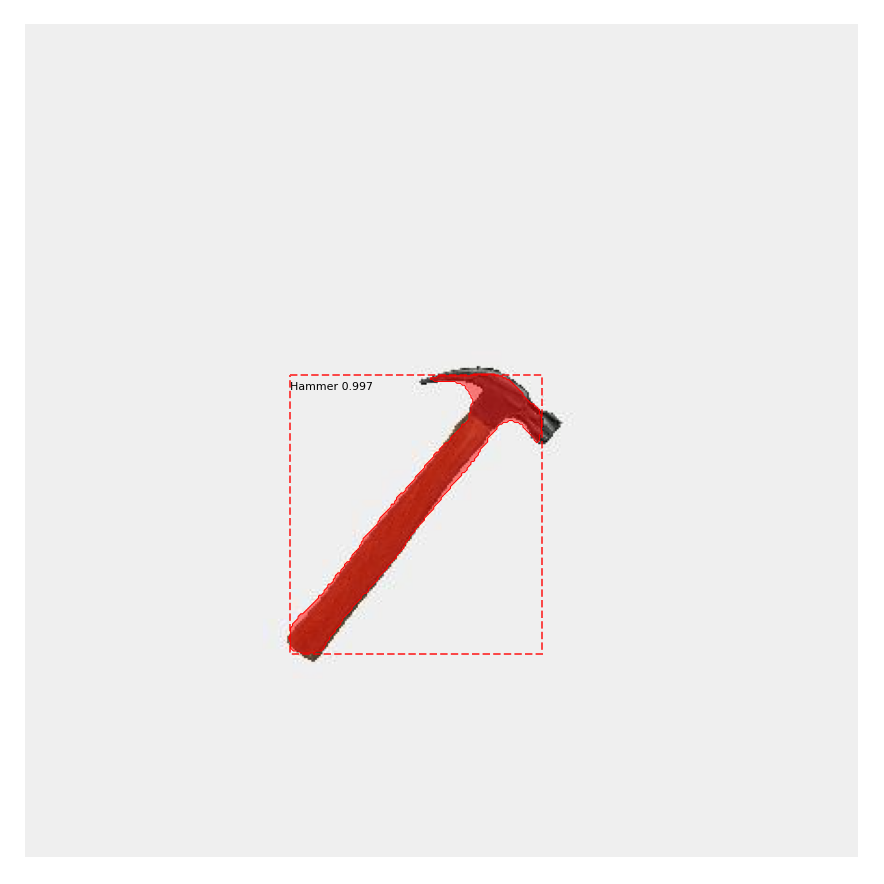

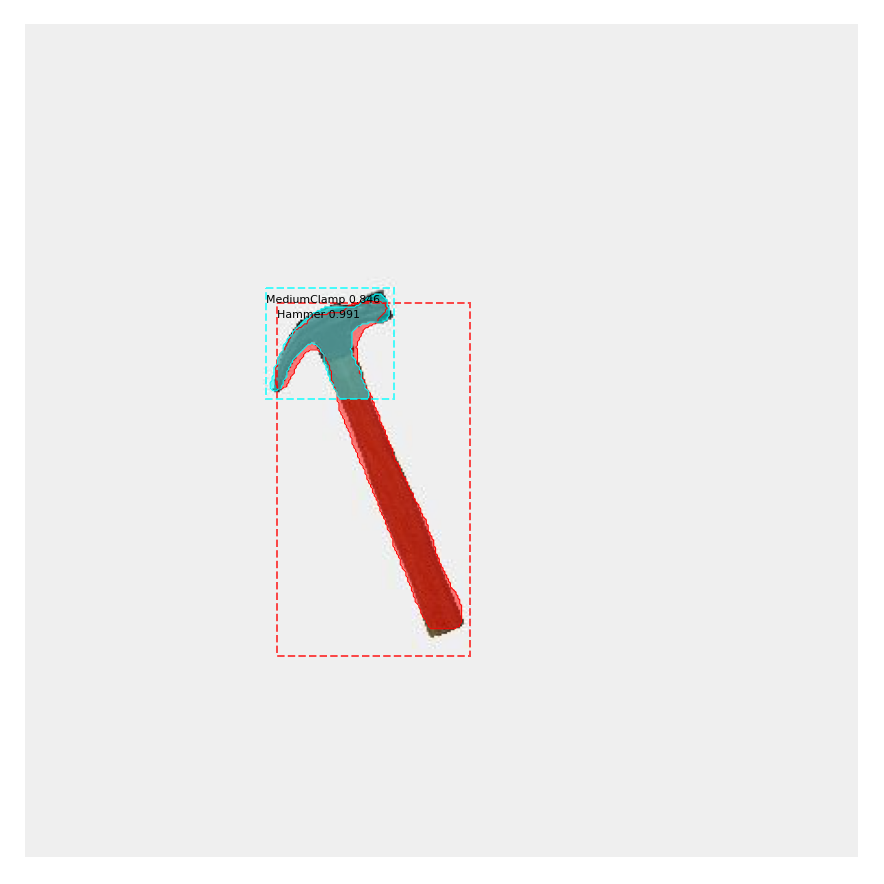


*** No instances to display *** 



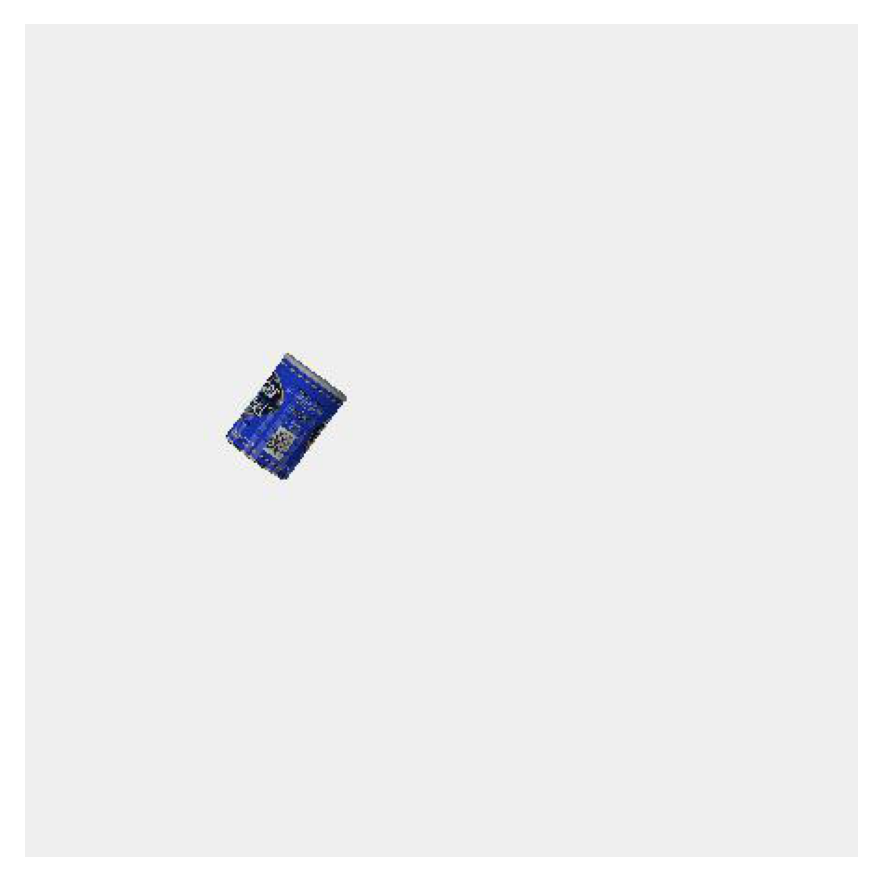


*** No instances to display *** 



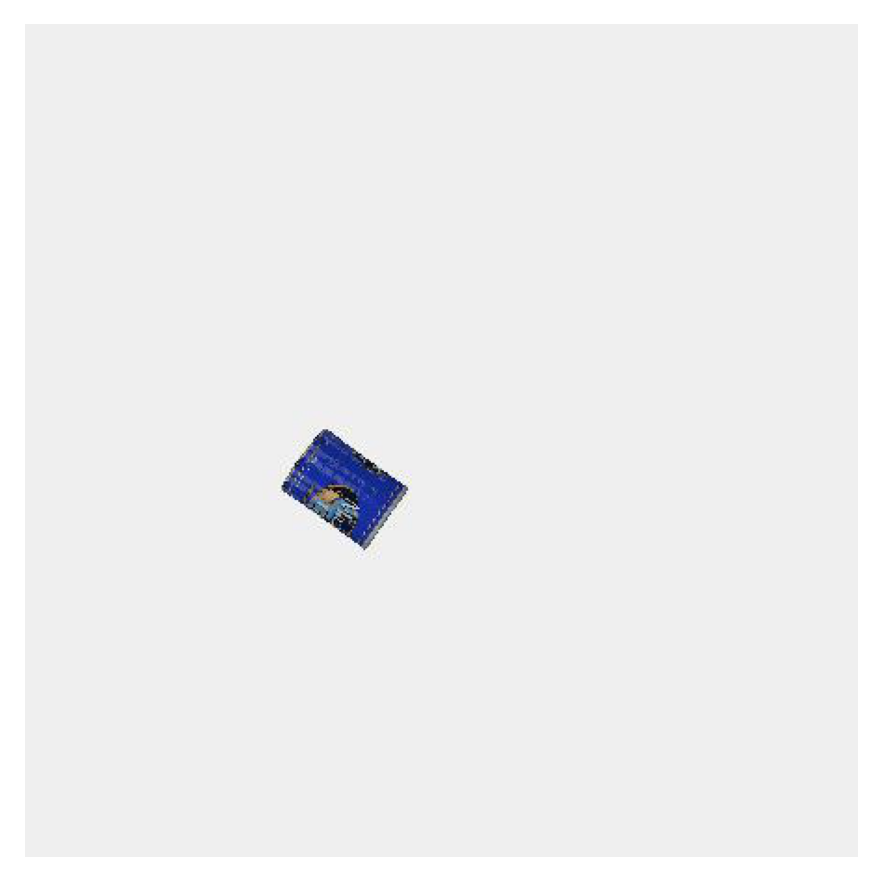

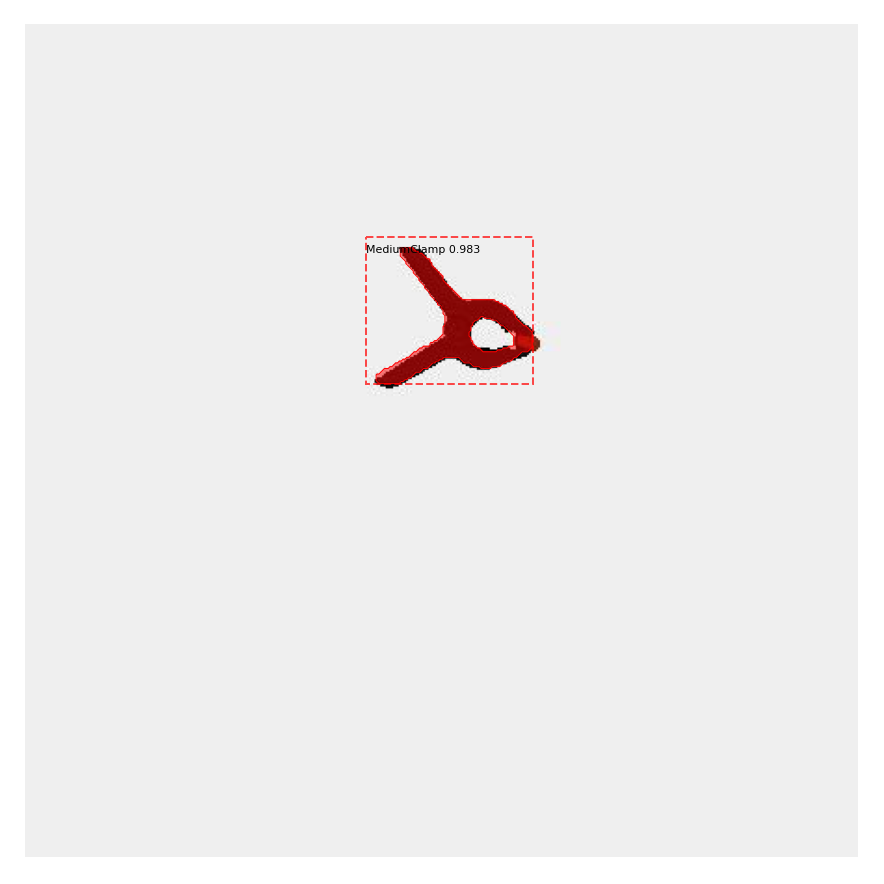

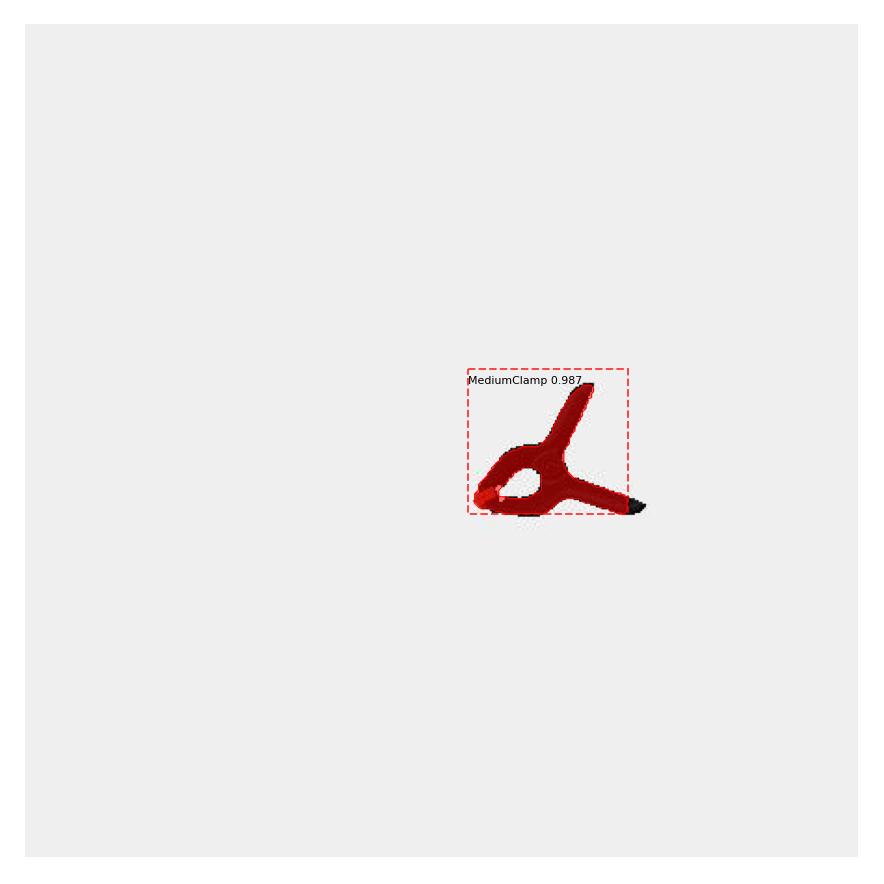

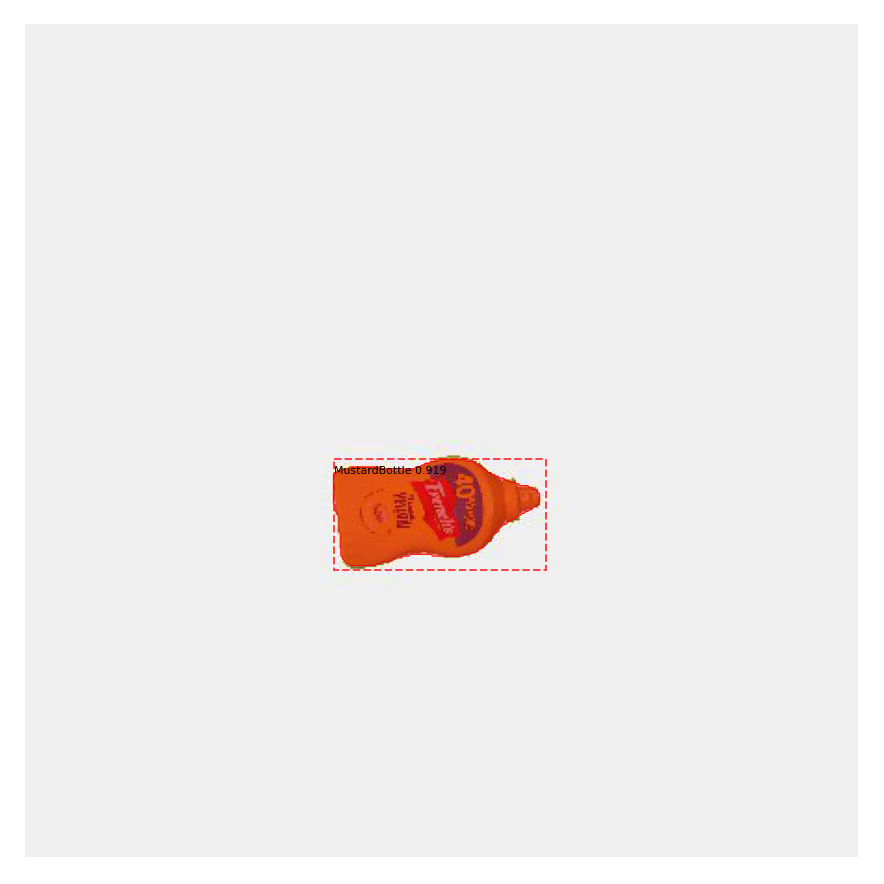

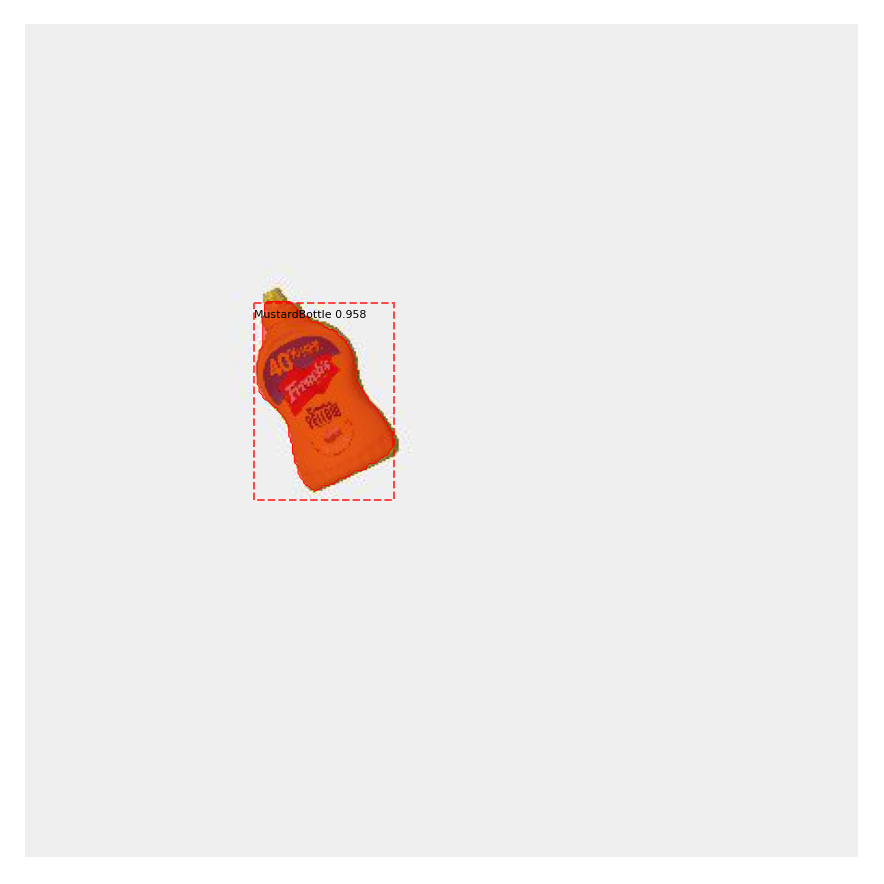

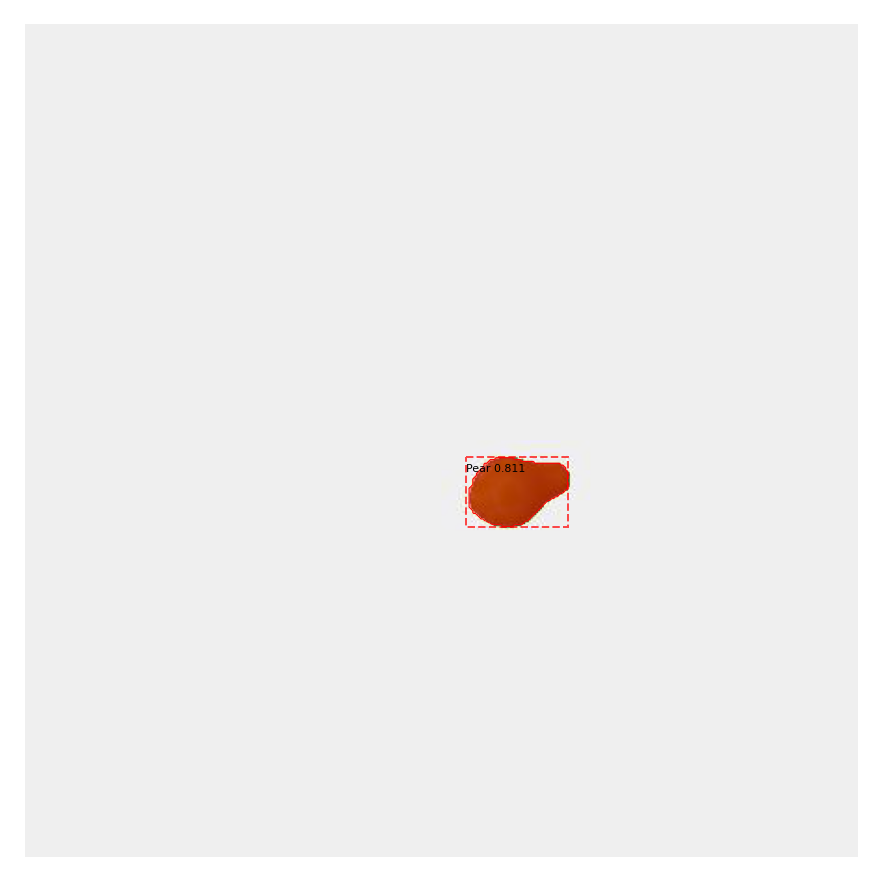

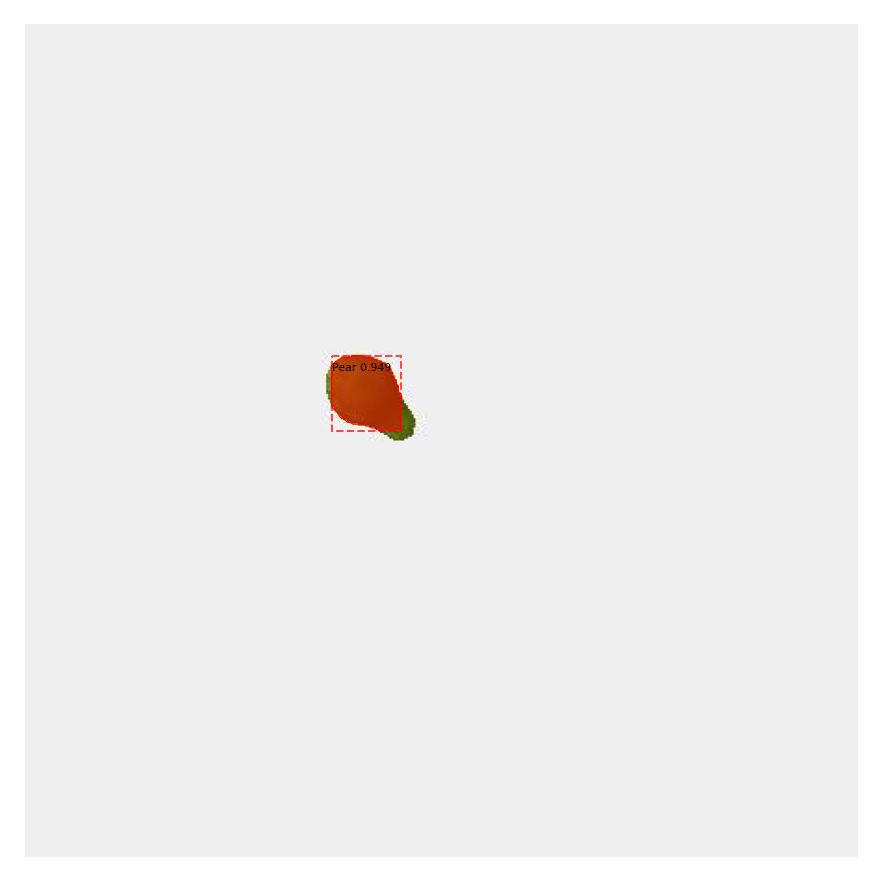

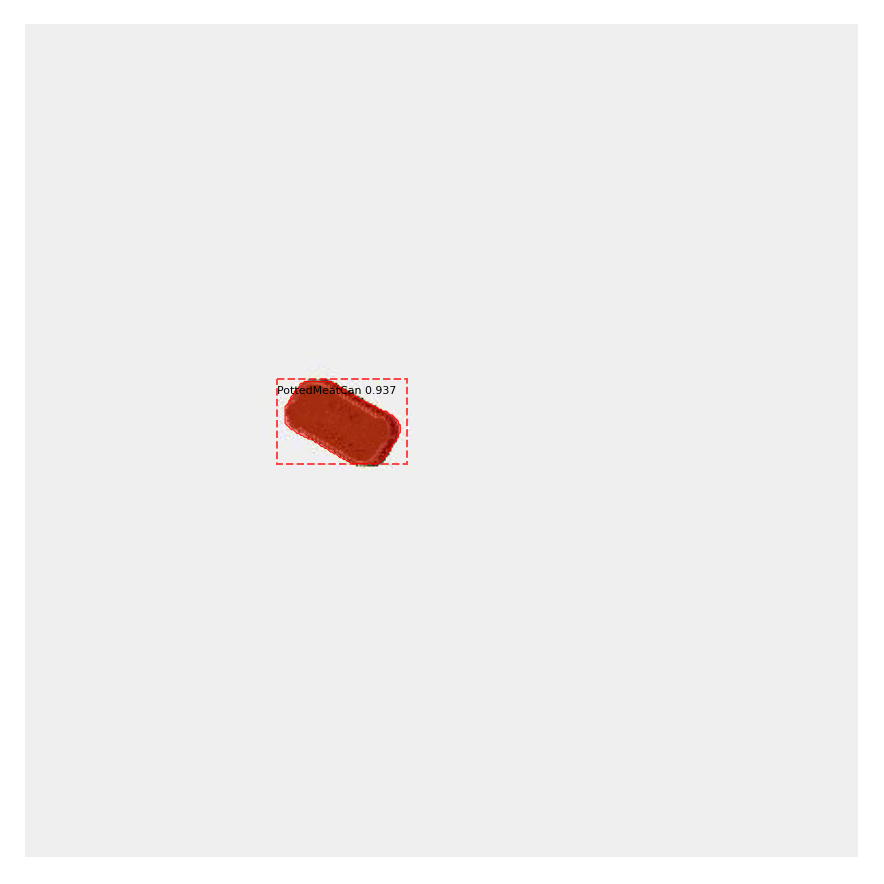


*** No instances to display *** 



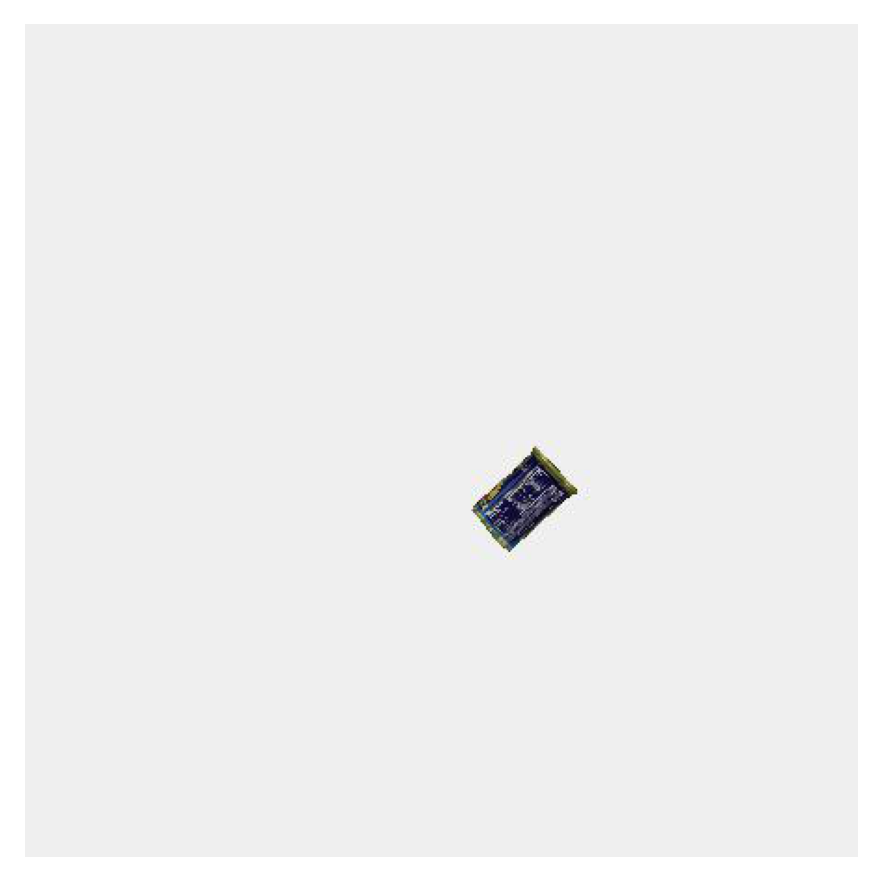


*** No instances to display *** 



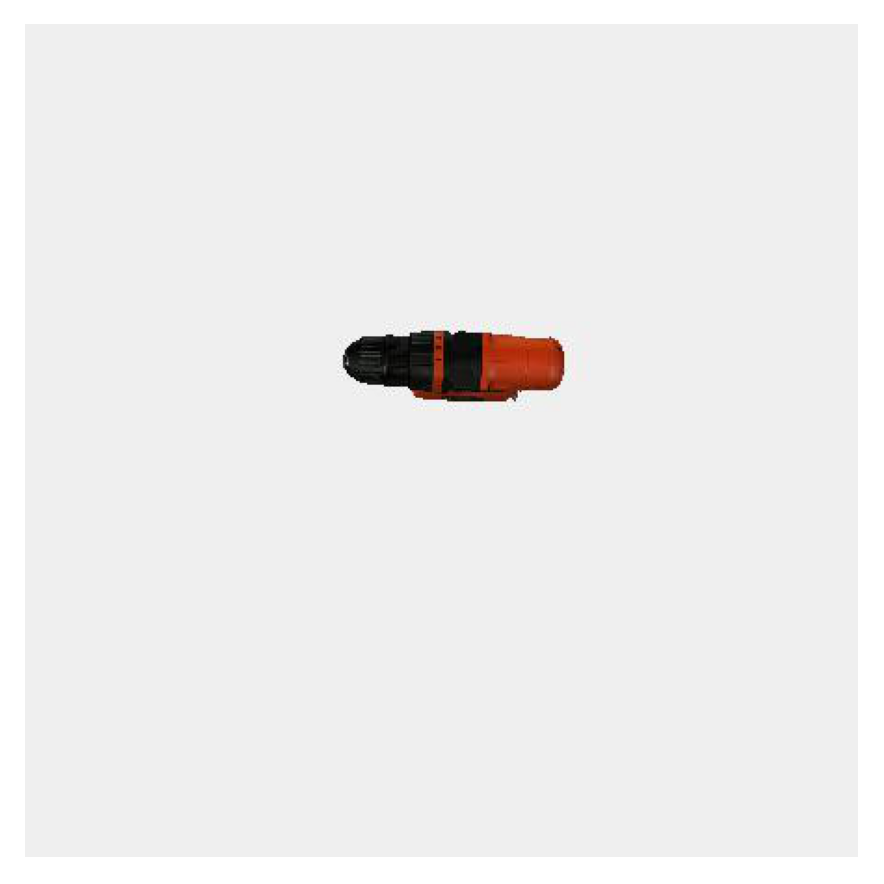

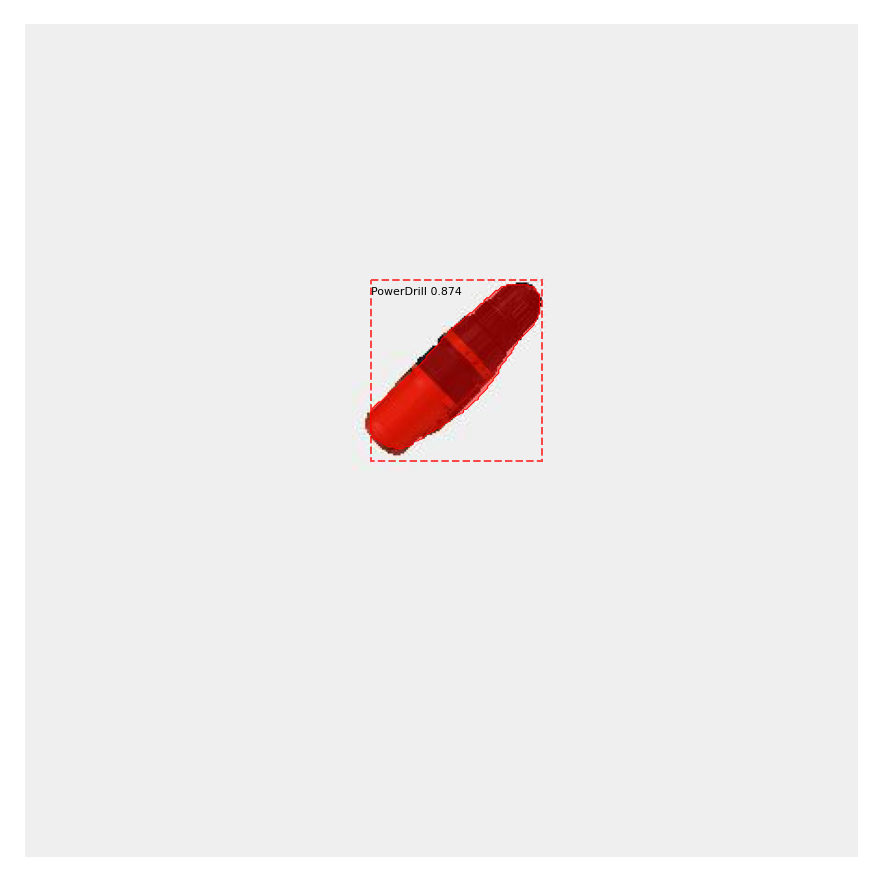

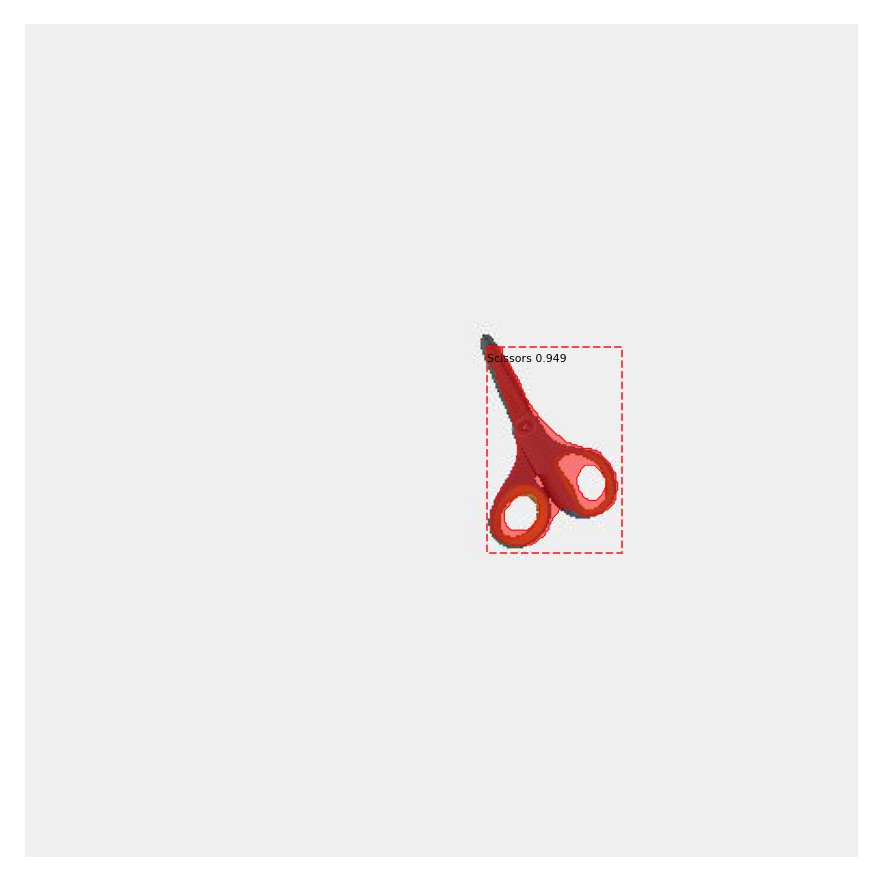

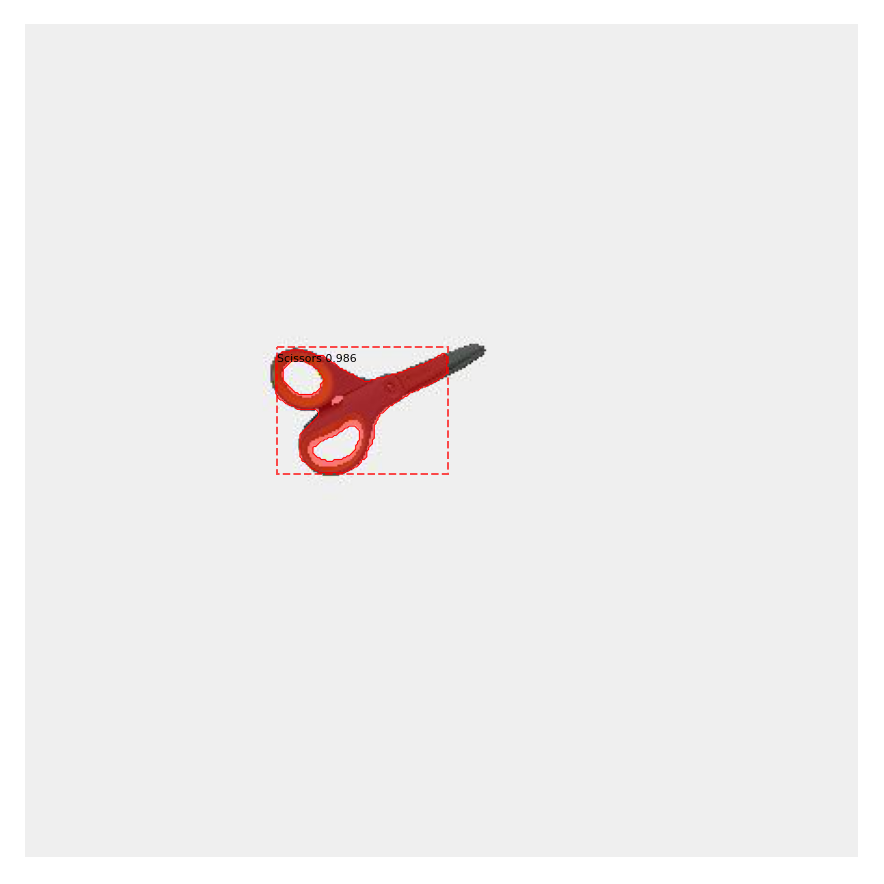

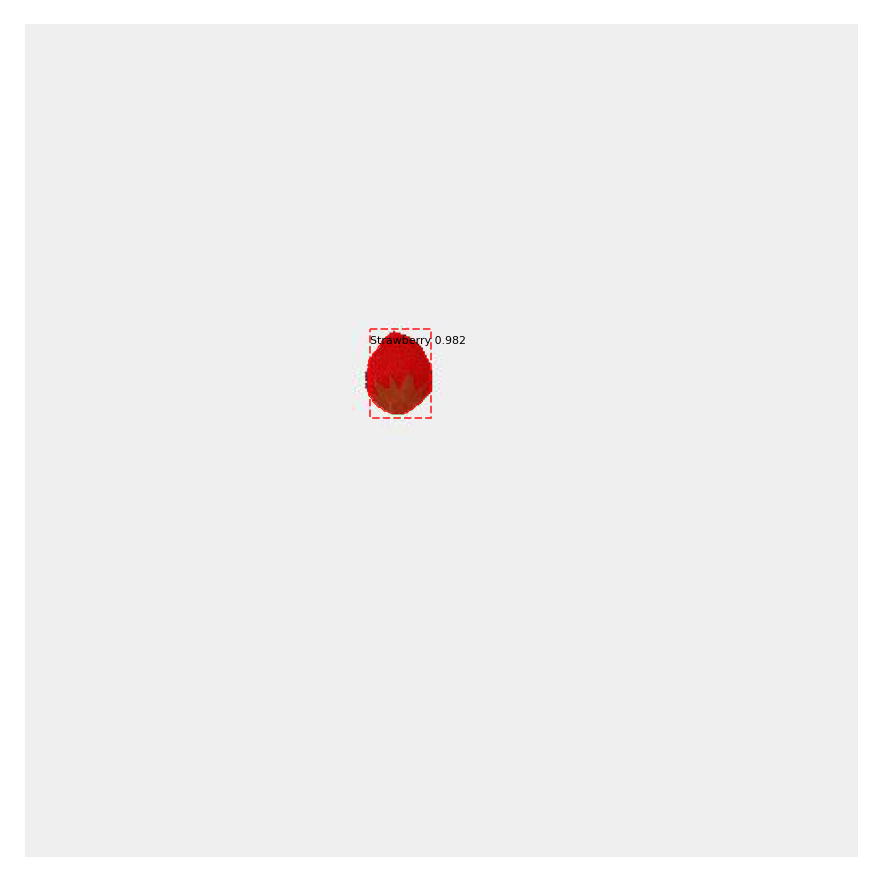

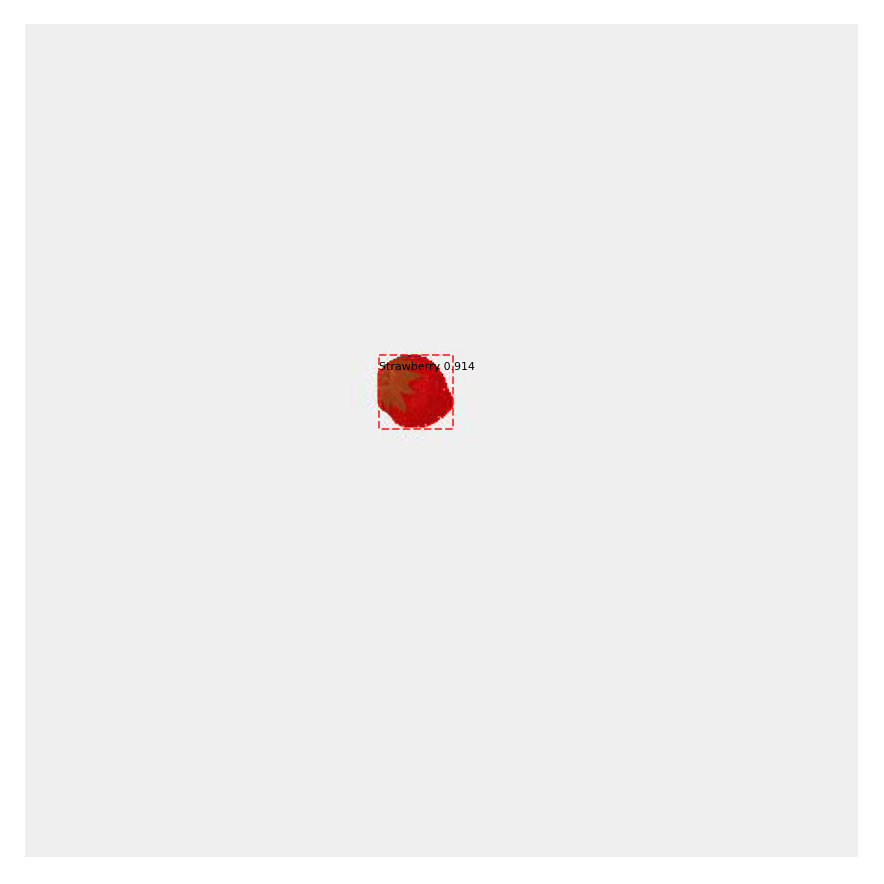

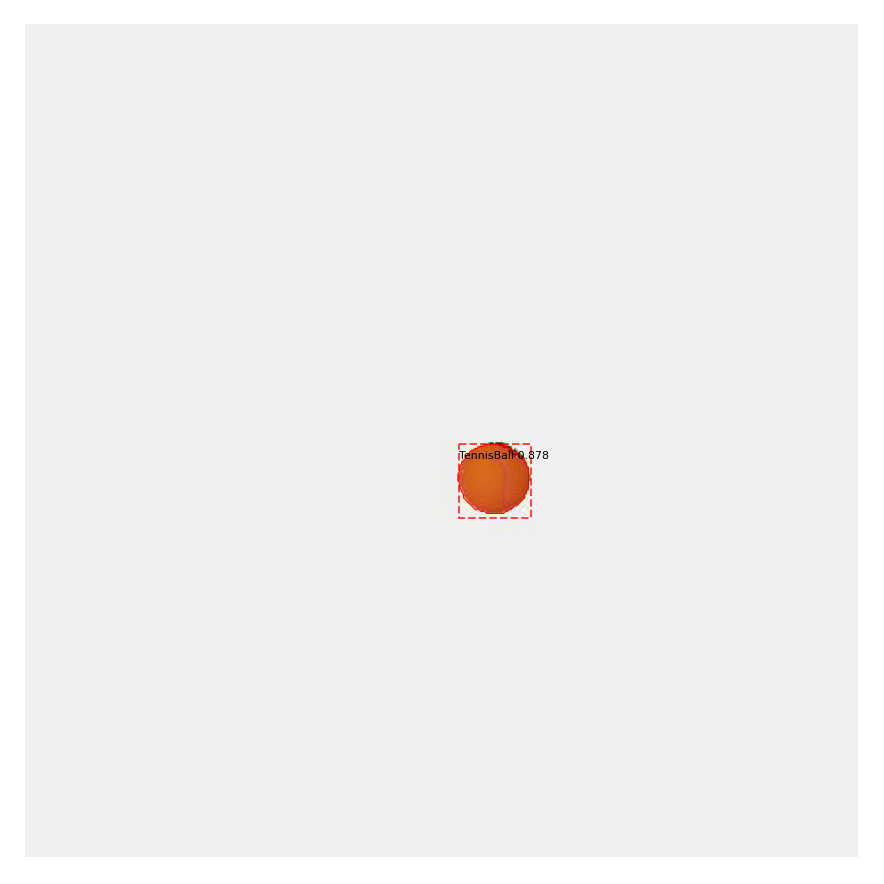


*** No instances to display *** 



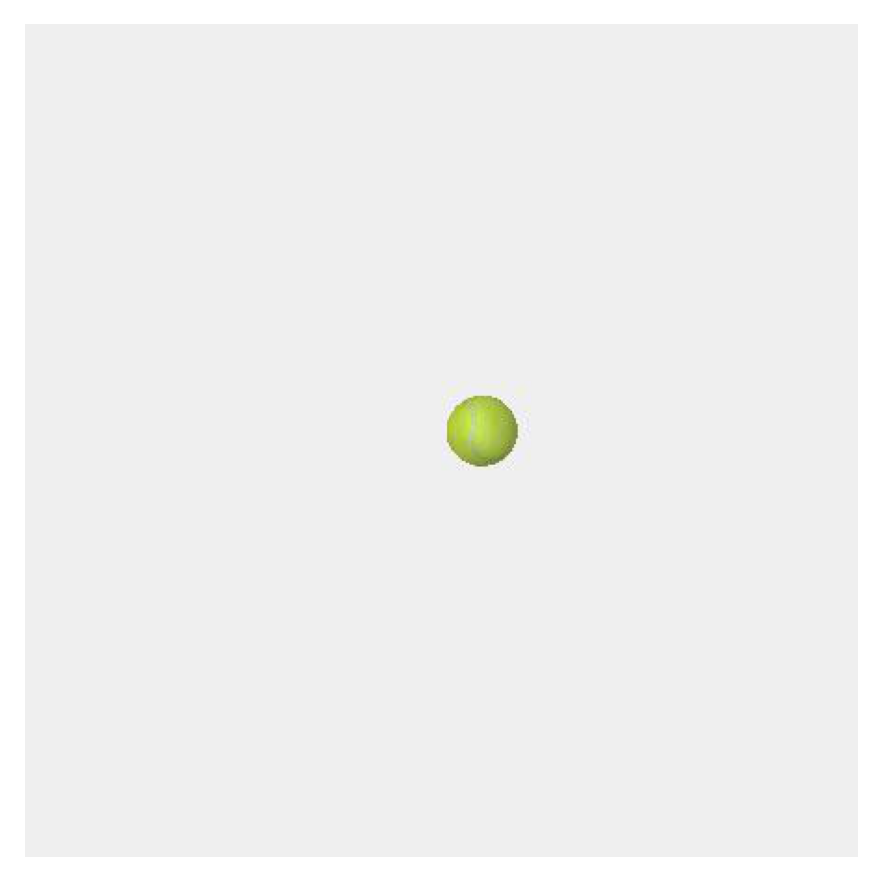

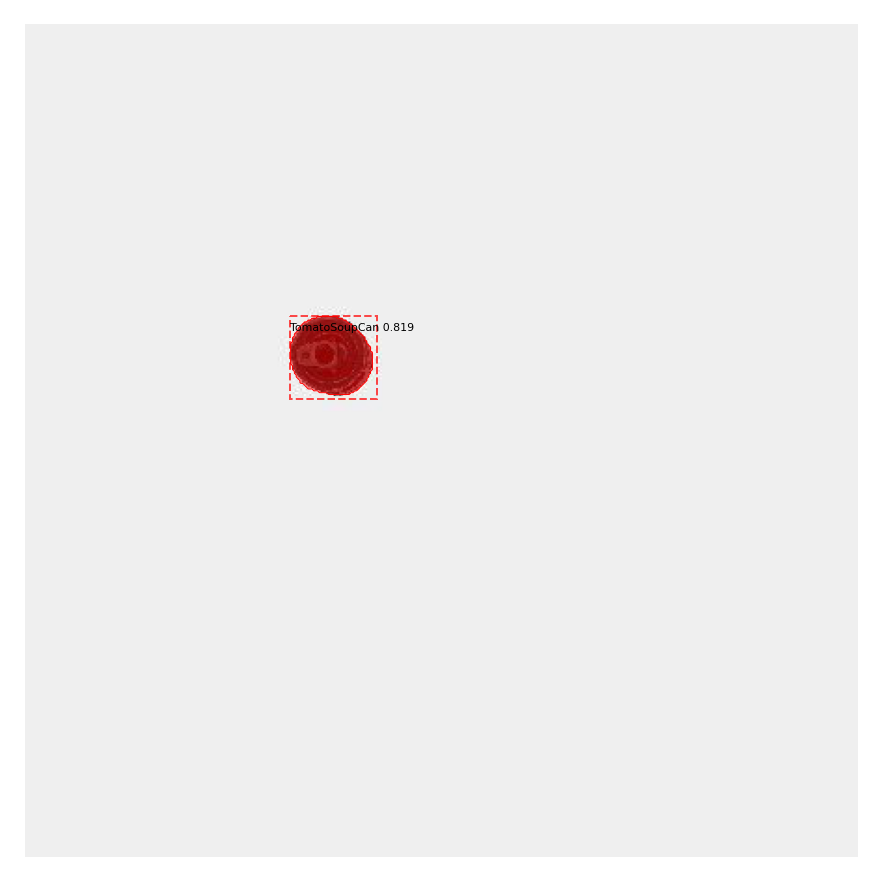


*** No instances to display *** 



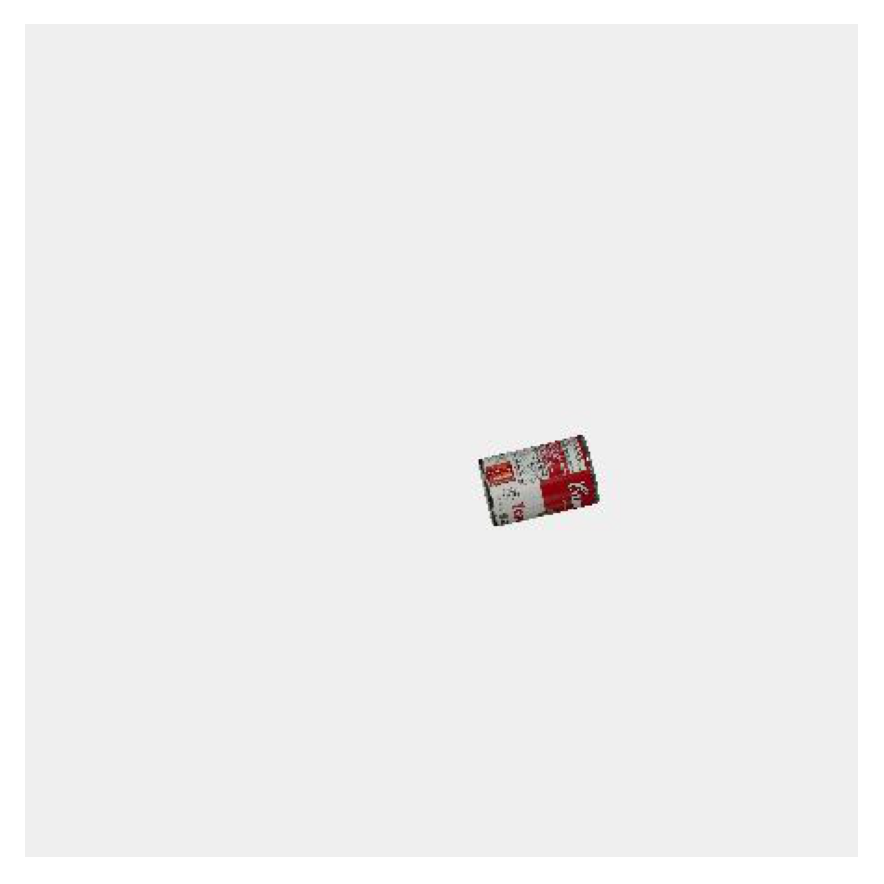

In [3]:
print(config.DETECTION_MIN_CONFIDENCE)

nr_of_inst = 2
test_objects = class_names

test_iso(nr_of_inst, test_objects)

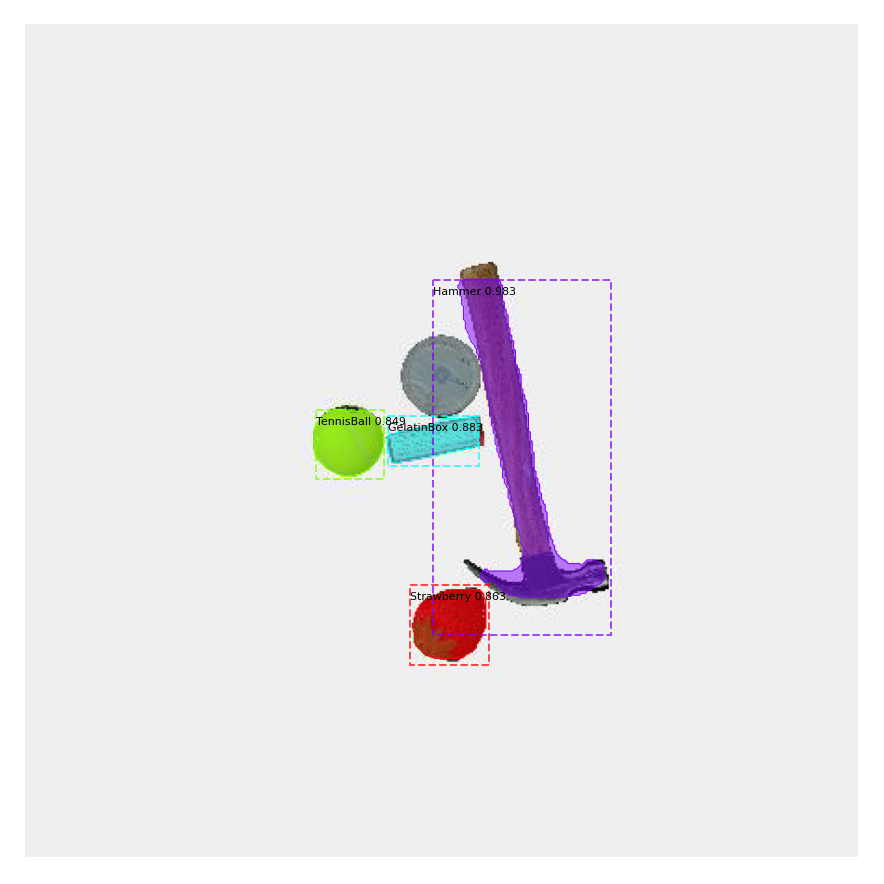

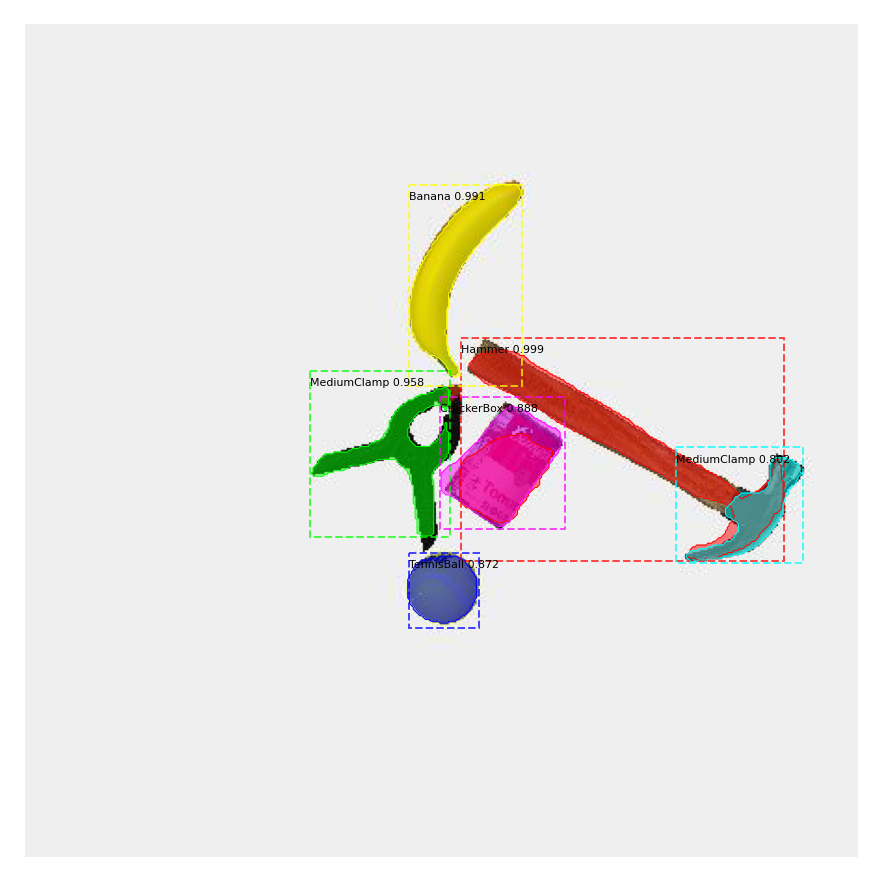

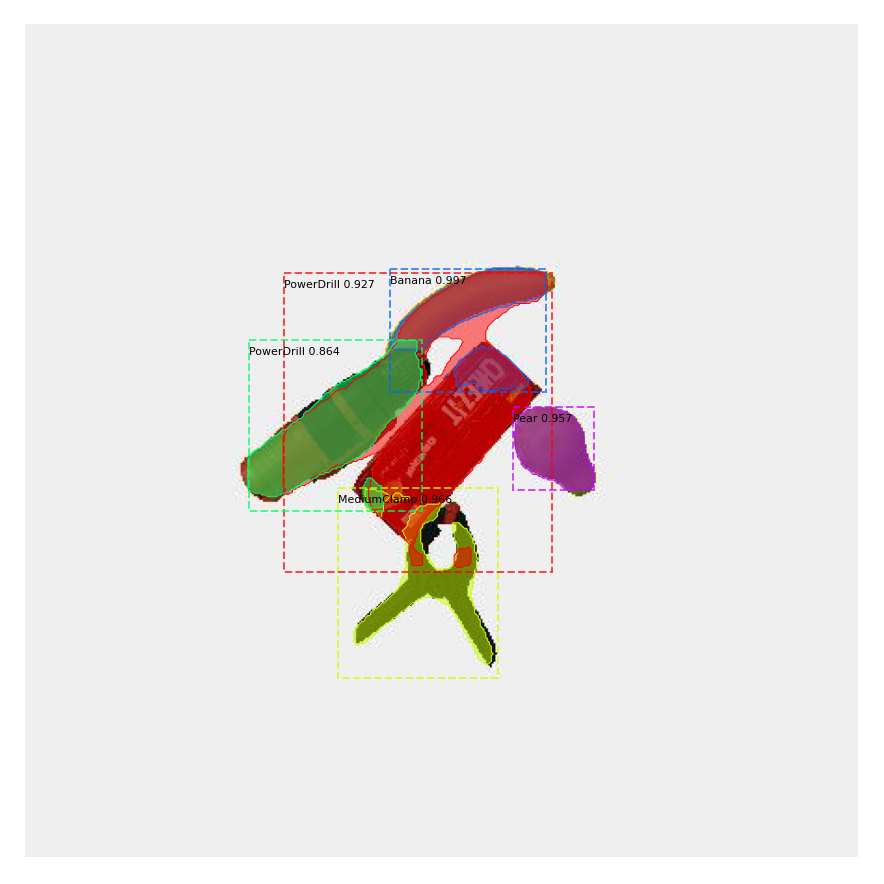

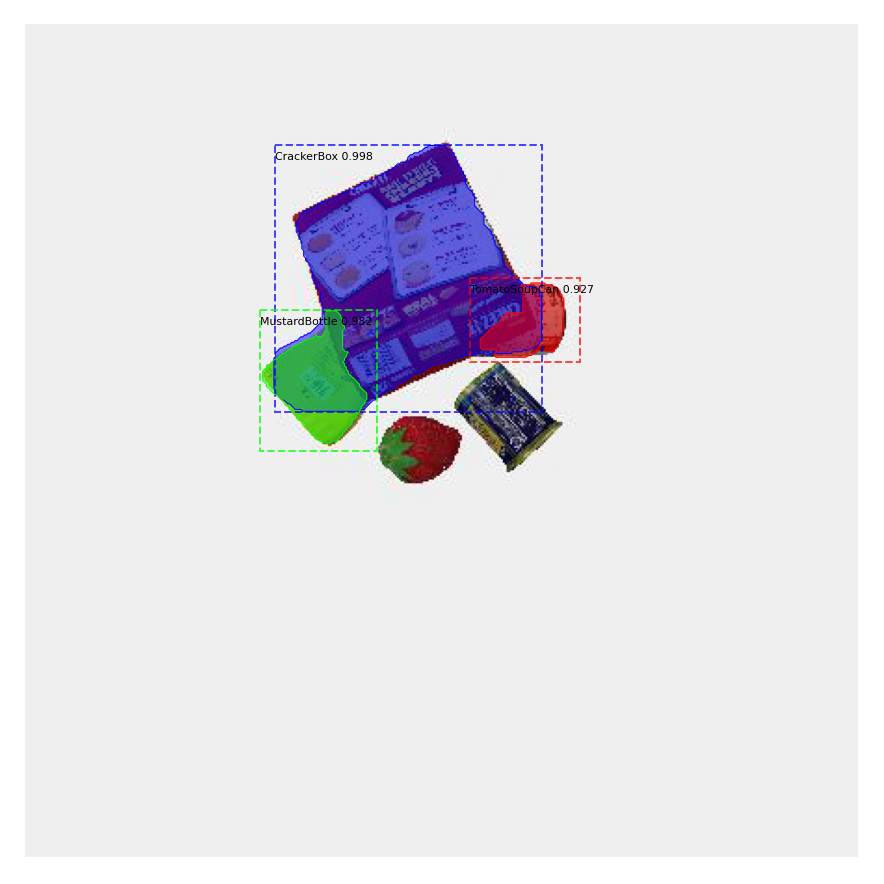

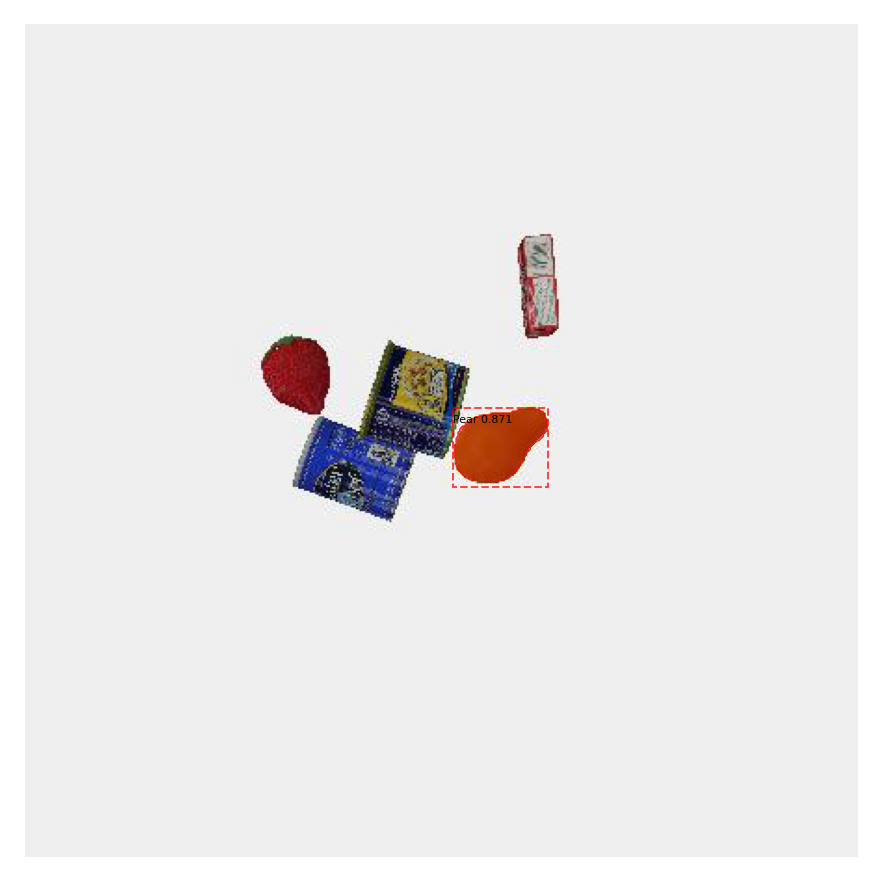

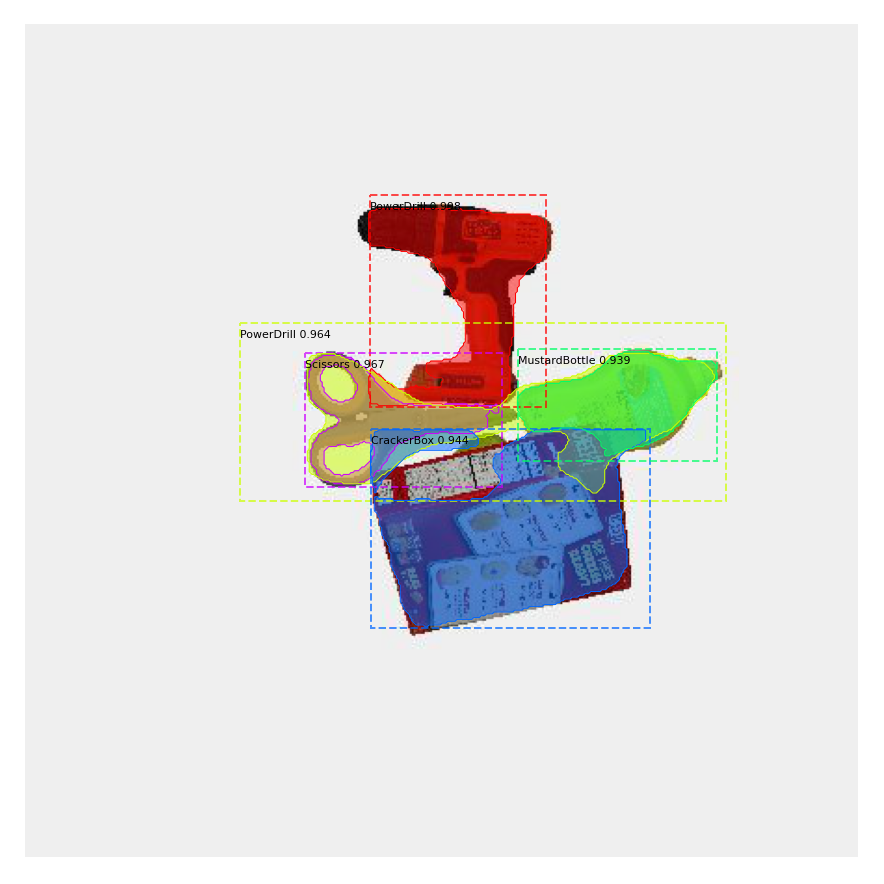

In [4]:
test_pack_pile()

# Misc

In [46]:
import numpy as np

a = np.zeros((10,10), dtype=np.int8)

b = np.ones((4,4), dtype=np.int8)

c = b*3

a[3:7,4:8] = c

print(a)

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 3 3 3 3 0 0]
 [0 0 0 0 3 3 3 3 0 0]
 [0 0 0 0 3 3 3 3 0 0]
 [0 0 0 0 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


In [44]:
from utils import YcbObjects

objects = YcbObjects('objects/ycb_objects',
                            mod_orn=['ChipsCan', 'MustardBottle', 'TomatoSoupCan'],
                            mod_stiffness=['Strawberry'])
target = 'Banana'

other_obj = objects.obj_names.copy()
other_obj.remove(target)

print(other_obj)
print(objects.obj_names)

['ChipsCan', 'CrackerBox', 'GelatinBox', 'Hammer', 'MasterChefCan', 'MediumClamp', 'MustardBottle', 'Pear', 'PottedMeatCan', 'PowerDrill', 'Scissors', 'Strawberry', 'TennisBall', 'TomatoSoupCan']
['Banana', 'ChipsCan', 'CrackerBox', 'GelatinBox', 'Hammer', 'MasterChefCan', 'MediumClamp', 'MustardBottle', 'Pear', 'PottedMeatCan', 'PowerDrill', 'Scissors', 'Strawberry', 'TennisBall', 'TomatoSoupCan']


In [35]:
import random
LOCATIONS = [(-0.2, -0.7), (-0.2, -0.2), (0.3, -0.7), (0.3, -0.2)]
random.shuffle(LOCATIONS)

print(LOCATIONS[0])

(-0.2, -0.2)


In [47]:
target_list = ['ChipsCan', 'CrackerBox', 'GelatinBox', 'Hammer', 'MasterChefCan', 'MediumClamp', 'MustardBottle', 'Pear', 'PottedMeatCan', 'PowerDrill', 'Scissors', 'Strawberry', 'TennisBall', 'TomatoSoupCan']
target = 'CrackerBox'

targetID = target_list.index(target)
print(targetID)

1


In [1]:
bbox = [3,6,4,8]

bbox +2 

TypeError: can only concatenate list (not "int") to list